## Modelling

It is now time to actually build our first model. The inital idea is we will fit both a linear and non linear model to both time series.

To begin with the linear model will use any seasonality we found from the EDA as well as the lags, the non linear model will only have access to the lags. 

We will use our helper functions from jfk_taxis that you can see in src/jfk_taxis

In [1]:
import pickle
import joblib
import pandas as pd
from jfk_taxis import run_forecasts, preprocess, fit_linear, fit_non_linear

In [2]:
# First reload the significant lags
with open("sig_lags_daily.pkl", "rb") as f:
    daily_lags = pickle.load(f)

with open("sig_lags_hourly.pkl", "rb") as f:
    hourly_lags = pickle.load(f)

In [3]:
# Get both the full daily and hourly time series
dir_path = "../data/processed/"
df_daily = pd.read_csv(f"{dir_path}ts_daily2011-2025.csv")
df_hourly = pd.read_csv(f"{dir_path}ts_hour2011-2025.csv")

# Convert dates to datetime objects
df_daily["pickup_date"] = pd.to_datetime(df_daily["pickup_date"])
df_hourly["dt"] = pd.to_datetime(df_hourly["dt"])


In [4]:
# To pass the time series through our helper functions they need to be a pandas series indexed by a datetime object:
ts_hourly = df_hourly["trips"]
ts_hourly.index = df_hourly["dt"]

ts_daily = df_daily["trips"]
ts_daily.index = df_daily["pickup_date"]

In [5]:
# We now need to split into test and train data, we will train on the pre 2024 data and test on 2024 onwards, approx a 90:10 split
ts_daily_train = ts_daily[:"2023-12-31"]
ts_daily_test = ts_daily["2024-01-01":]

ts_hourly_train = ts_hourly[:"2023-12-31"]
ts_hourly_test = ts_hourly["2024-01-01":]

In [19]:
ts_hourly_test

dt
2024-01-01 00:00:00    150
2024-01-01 01:00:00     68
2024-01-01 02:00:00     21
2024-01-01 03:00:00     18
2024-01-01 04:00:00     26
                      ... 
2025-06-30 19:00:00    355
2025-06-30 20:00:00    395
2025-06-30 21:00:00    335
2025-06-30 22:00:00    337
2025-06-30 23:00:00    400
Name: trips, Length: 13119, dtype: int64

In [20]:
ts_hourly_train

dt
2011-01-01 00:00:00     82
2011-01-01 01:00:00     72
2011-01-01 02:00:00     15
2011-01-01 03:00:00     12
2011-01-01 04:00:00     11
                      ... 
2023-12-31 19:00:00    426
2023-12-31 20:00:00    317
2023-12-31 21:00:00    371
2023-12-31 22:00:00    313
2023-12-31 23:00:00    305
Name: trips, Length: 112870, dtype: int64

In [21]:
ts_daily_train

pickup_date
2011-01-01    2539
2011-01-02    3438
2011-01-03    8304
2011-01-04    7369
2011-01-05    6155
              ... 
2023-12-27    6027
2023-12-28    6014
2023-12-29    5755
2023-12-30    5733
2023-12-31    5296
Name: trips, Length: 4748, dtype: int64

In [36]:
# Create models and forecasts for daily ts

# 181 days in 2025 in the data, meaning 546 is the max number of steps we can forecast

# Steps for the forecast
steps = [1, 2, 3, 7, 14, 28, 30, 60, 180, 365, 500, 546]

# Fourier features (yearly and weekly)
fourier_features = ["YE", "W"]


In [37]:
# Create non linear design and traget matricies
(X_non_linear, y_non_linear, dp_non_linear) = preprocess(daily_lags, False, 0, fourier_features, "D", ts_daily_train)

# Store non linear design matricies
non_linear_design = {
    "base_non_linear": (X_non_linear, y_non_linear, dp_non_linear)
}

linear_design = {}

# Create linear design and target matricies 
for i in [1,2,3,4,5]:
    (X,y, dp_linear) = preprocess(daily_lags, True, i, fourier_features, "D", ts_daily_train)
    linear_design[f"linear_order{i}"] = (X,y,dp_linear)





In [38]:
# Train models
non_linear_models = {}
linear_models = {}


for key, value in non_linear_design.items():
    non_linear_models[key] = (fit_non_linear(value[0], value[1]), value[2], None)

for key, value in linear_design.items():
    linear_models[key] = (fit_linear(value[0], value[1]), value[2], None)



In [39]:
# Save models
for key, value in linear_models.items():
    joblib.dump(value[0], f"{key}.pkl")
    joblib.dump(value[1], f"{key}_dp.pkl")
    joblib.dump(value[2], f"{key}_hybrid.pkl")

for key, value in non_linear_models.items():
    joblib.dump(value[0], f"{key}.pkl")
    joblib.dump(value[1], f"{key}_dp.pkl")
    joblib.dump(value[2], f"{key}_hybrid.pkl")

# Save the keys so we can reload easily
joblib.dump(list(linear_models.keys()), f"Linear_keys.pkl")
joblib.dump(list(non_linear_models.keys()), f"Non_linear_keys.pkl")



['Non_linear_keys.pkl']

In [41]:
# Load models
linear_keys = joblib.load("Linear_keys.pkl")
non_linear_keys = joblib.load("Non_linear_keys.pkl")

# Create separate load dicts to avoid contamination when running cells out of order
non_linear_models_loaded = {}
linear_models_loaded = {}


for key in linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    linear_models_loaded[key] = (model, dp, hybrid)

for key in non_linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    non_linear_models_loaded[key] = (model, dp, hybrid)
   


MAE Linear: 324.40 for step = 1, model = linear_order1
MAE Linear: 344.90 for step = 1, model = linear_order2
MAE Linear: 378.40 for step = 1, model = linear_order3
MAE Linear: 294.78 for step = 1, model = linear_order4
MAE Linear: 294.78 for step = 1, model = linear_order5
MAE Non Linear: 225.98 for step = 1, model = base_non_linear
Naive MAE: MAE = 342.00



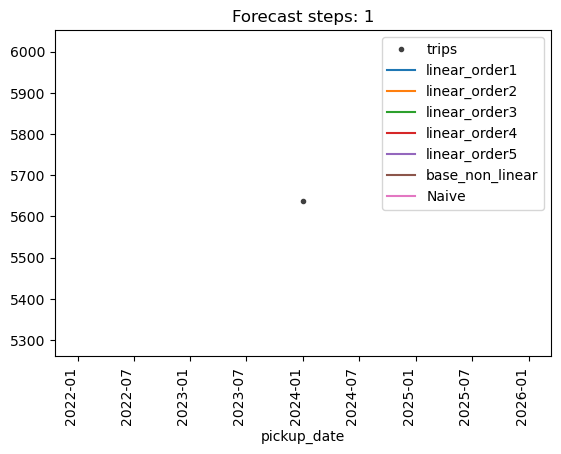

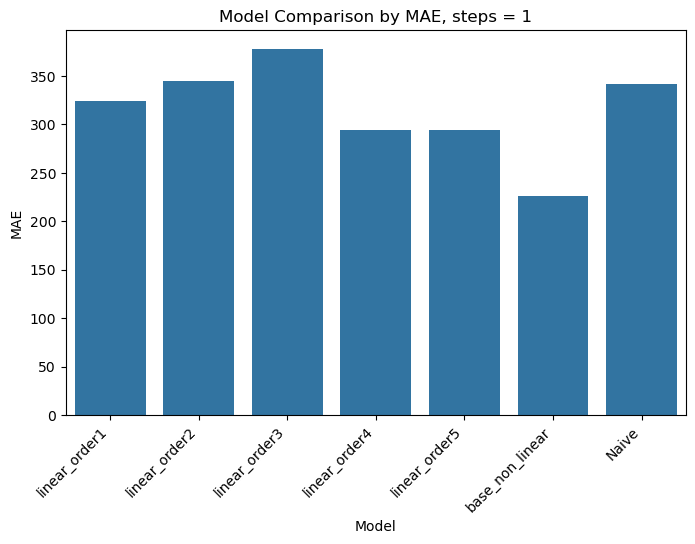

MAE Linear: 524.57 for step = 2, model = linear_order1
MAE Linear: 517.60 for step = 2, model = linear_order2
MAE Linear: 508.16 for step = 2, model = linear_order3
MAE Linear: 484.41 for step = 2, model = linear_order4
MAE Linear: 484.41 for step = 2, model = linear_order5
MAE Non Linear: 433.53 for step = 2, model = base_non_linear
Naive MAE: MAE = 664.00



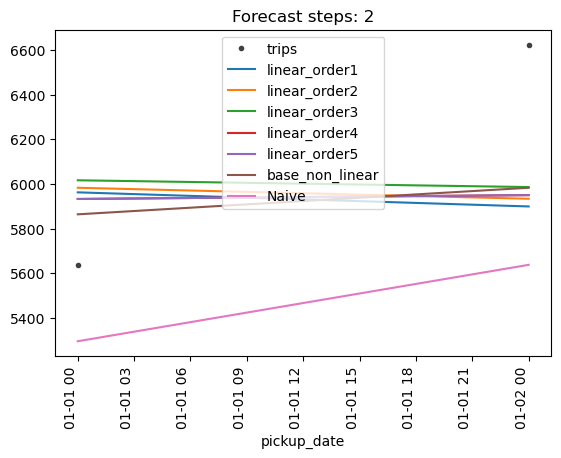

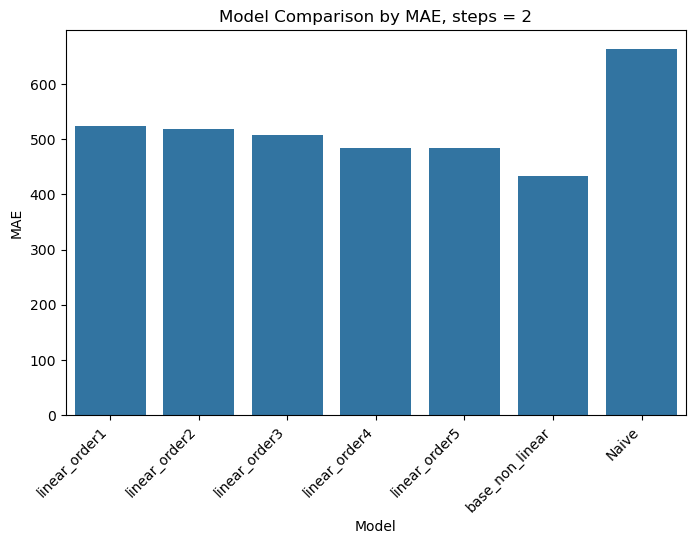

MAE Linear: 545.60 for step = 3, model = linear_order1
MAE Linear: 527.92 for step = 3, model = linear_order2
MAE Linear: 501.54 for step = 3, model = linear_order3
MAE Linear: 491.10 for step = 3, model = linear_order4
MAE Linear: 491.10 for step = 3, model = linear_order5
MAE Non Linear: 352.10 for step = 3, model = base_non_linear
Naive MAE: MAE = 604.33



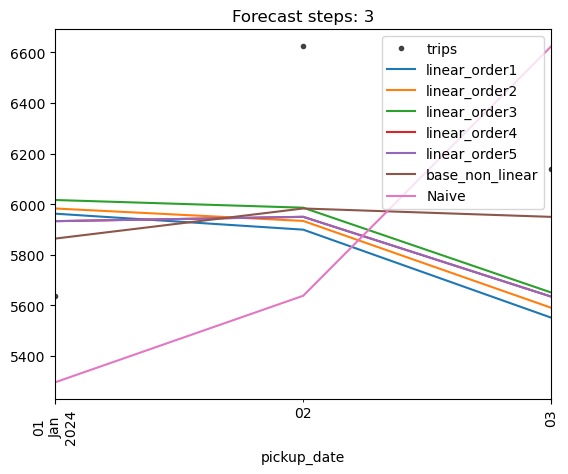

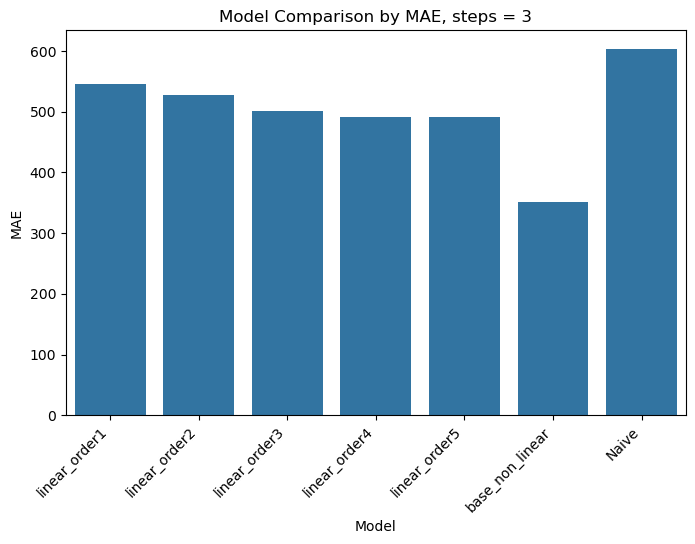

MAE Linear: 439.14 for step = 7, model = linear_order1
MAE Linear: 446.66 for step = 7, model = linear_order2
MAE Linear: 459.96 for step = 7, model = linear_order3
MAE Linear: 455.13 for step = 7, model = linear_order4
MAE Linear: 455.13 for step = 7, model = linear_order5
MAE Non Linear: 361.43 for step = 7, model = base_non_linear
Naive MAE: MAE = 592.71



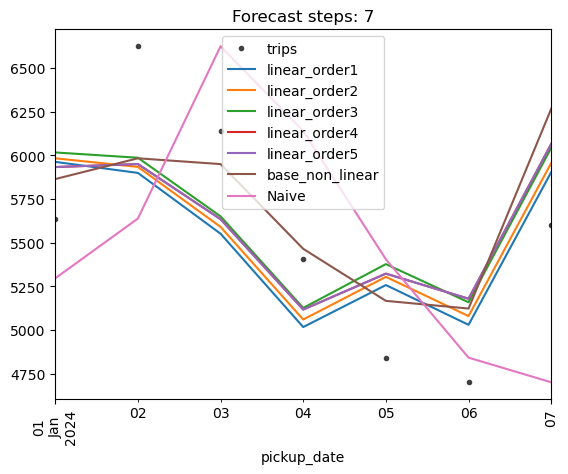

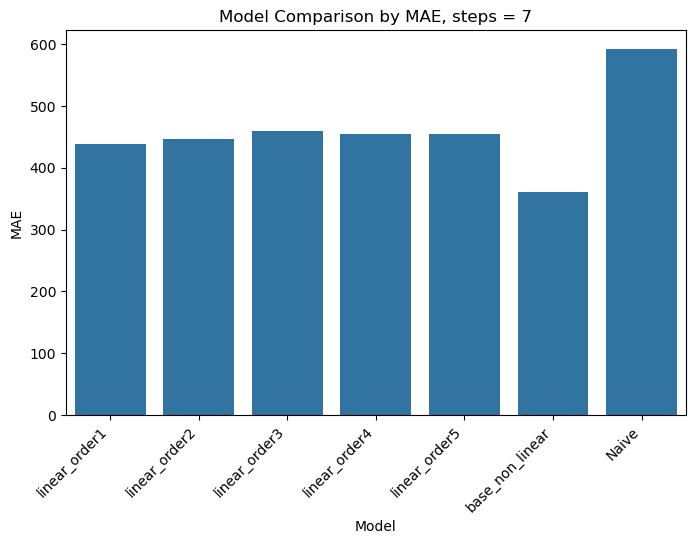

MAE Linear: 469.41 for step = 14, model = linear_order1
MAE Linear: 497.12 for step = 14, model = linear_order2
MAE Linear: 559.95 for step = 14, model = linear_order3
MAE Linear: 596.20 for step = 14, model = linear_order4
MAE Linear: 596.20 for step = 14, model = linear_order5
MAE Non Linear: 483.97 for step = 14, model = base_non_linear
Naive MAE: MAE = 537.71



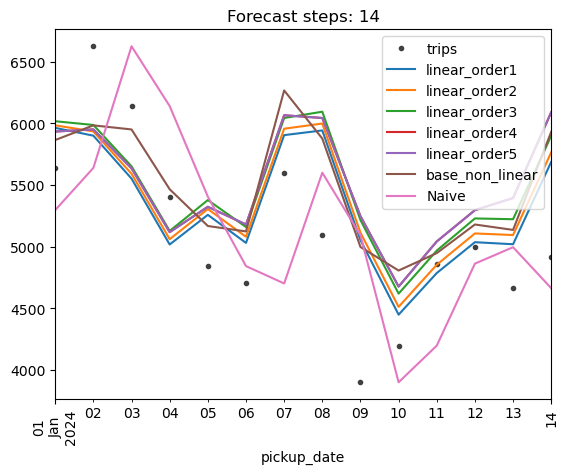

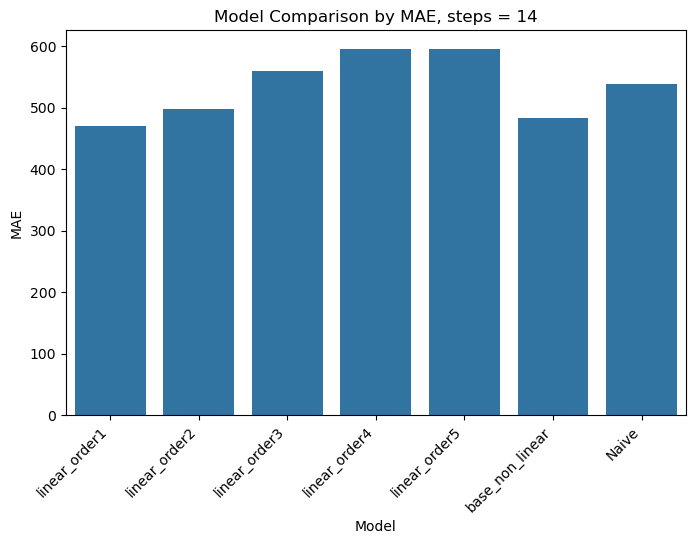

MAE Linear: 399.04 for step = 28, model = linear_order1
MAE Linear: 451.10 for step = 28, model = linear_order2
MAE Linear: 555.23 for step = 28, model = linear_order3
MAE Linear: 815.38 for step = 28, model = linear_order4
MAE Linear: 815.38 for step = 28, model = linear_order5
MAE Non Linear: 538.51 for step = 28, model = base_non_linear
Naive MAE: MAE = 543.11



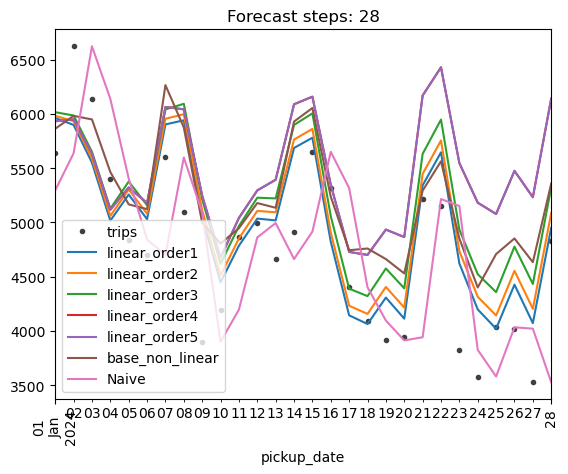

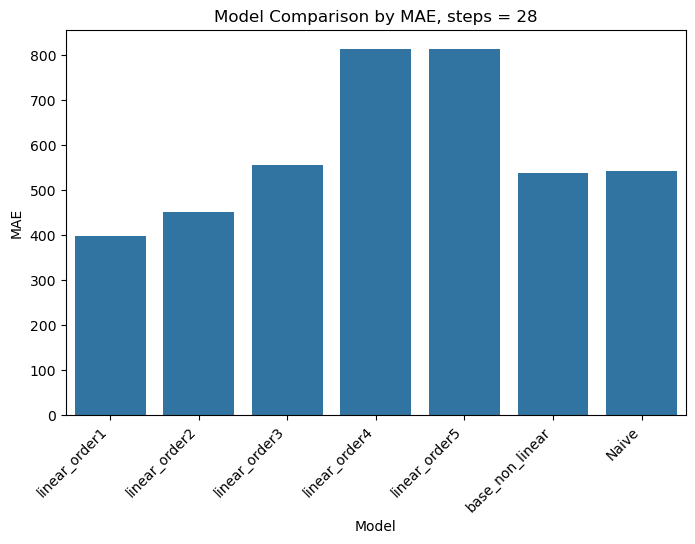

MAE Linear: 403.46 for step = 30, model = linear_order1
MAE Linear: 461.48 for step = 30, model = linear_order2
MAE Linear: 575.23 for step = 30, model = linear_order3
MAE Linear: 869.44 for step = 30, model = linear_order4
MAE Linear: 869.44 for step = 30, model = linear_order5
MAE Non Linear: 559.73 for step = 30, model = base_non_linear
Naive MAE: MAE = 545.37



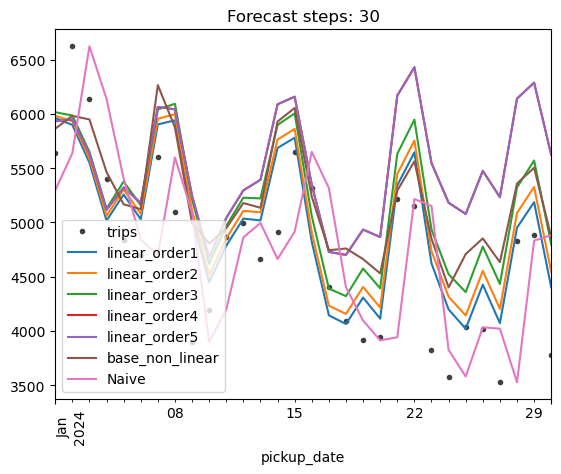

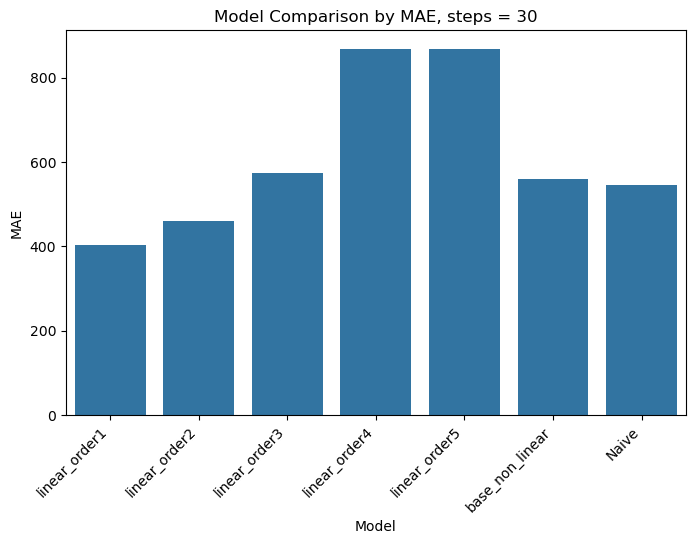

MAE Linear: 391.77 for step = 60, model = linear_order1
MAE Linear: 454.99 for step = 60, model = linear_order2
MAE Linear: 643.54 for step = 60, model = linear_order3
MAE Linear: 966.48 for step = 60, model = linear_order4
MAE Linear: 966.48 for step = 60, model = linear_order5
MAE Non Linear: 637.01 for step = 60, model = base_non_linear
Naive MAE: MAE = 541.90



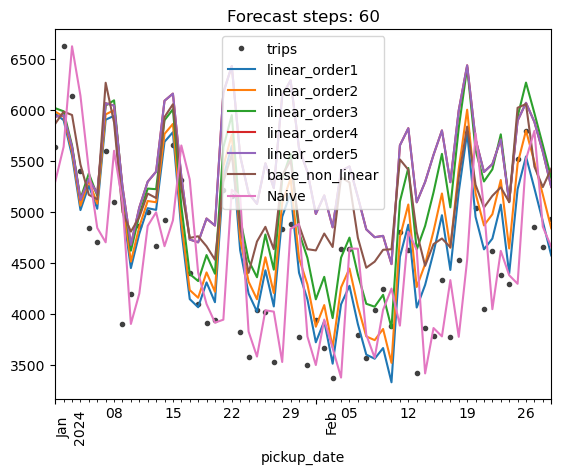

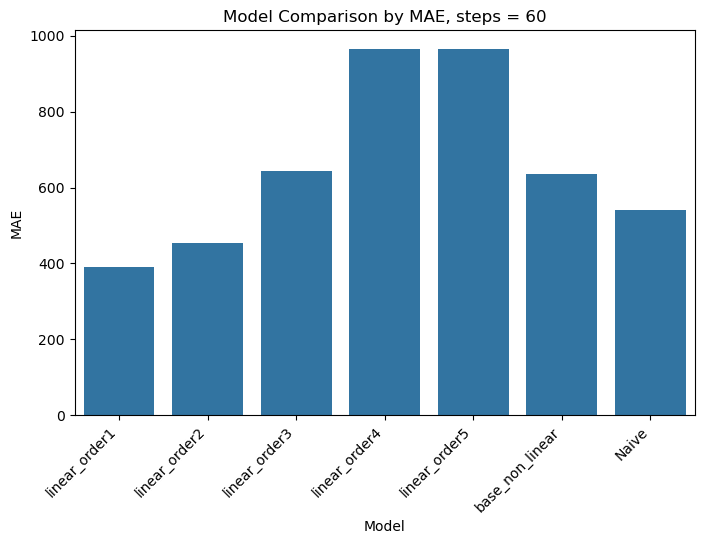

MAE Linear: 522.13 for step = 180, model = linear_order1
MAE Linear: 395.39 for step = 180, model = linear_order2
MAE Linear: 857.90 for step = 180, model = linear_order3
MAE Linear: 760.48 for step = 180, model = linear_order4
MAE Linear: 760.48 for step = 180, model = linear_order5
MAE Non Linear: 587.16 for step = 180, model = base_non_linear
Naive MAE: MAE = 583.99



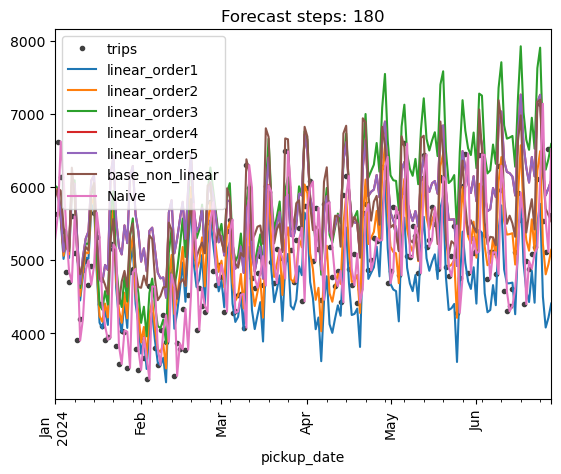

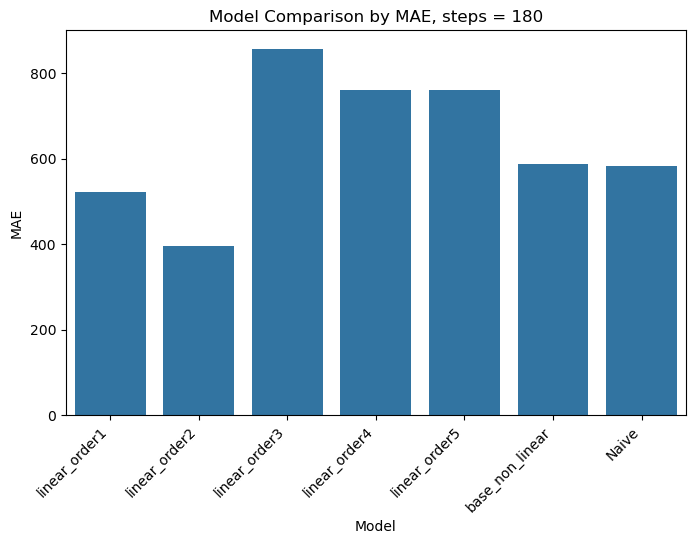

MAE Linear: 968.71 for step = 365, model = linear_order1
MAE Linear: 500.23 for step = 365, model = linear_order2
MAE Linear: 1434.15 for step = 365, model = linear_order3
MAE Linear: 1150.89 for step = 365, model = linear_order4
MAE Linear: 1150.89 for step = 365, model = linear_order5
MAE Non Linear: 574.71 for step = 365, model = base_non_linear
Naive MAE: MAE = 613.42



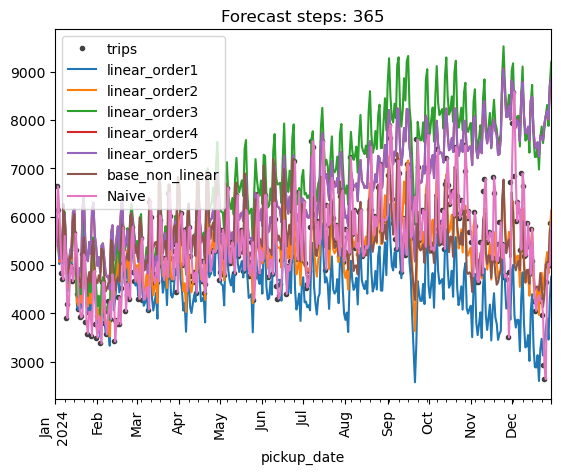

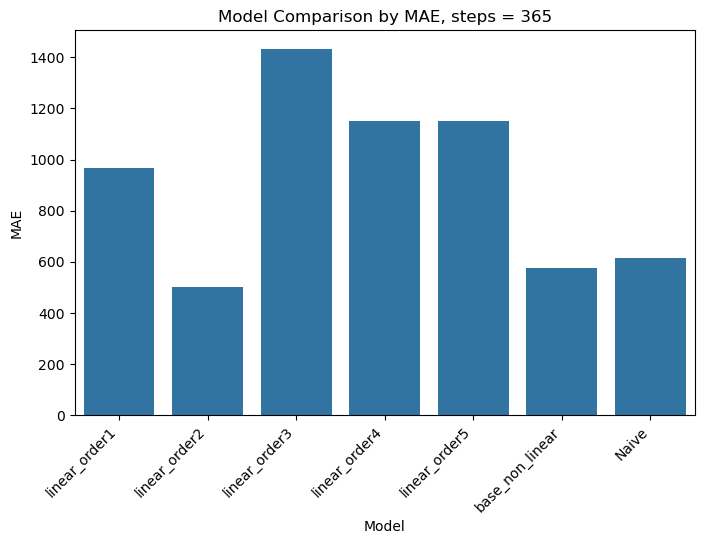

MAE Linear: 1113.86 for step = 500, model = linear_order1
MAE Linear: 474.77 for step = 500, model = linear_order2
MAE Linear: 2039.27 for step = 500, model = linear_order3
MAE Linear: 1823.58 for step = 500, model = linear_order4
MAE Linear: 1823.58 for step = 500, model = linear_order5
MAE Non Linear: 569.90 for step = 500, model = base_non_linear
Naive MAE: MAE = 619.86



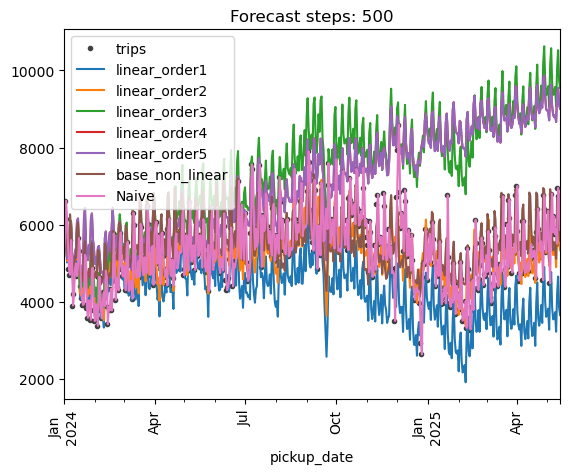

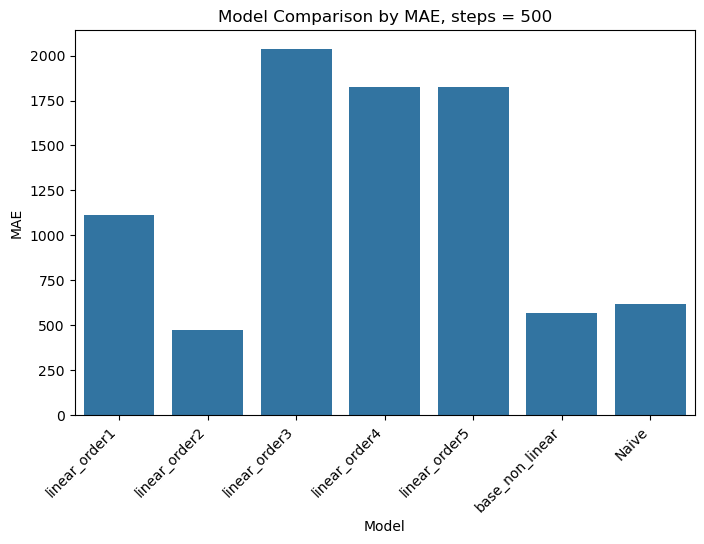

MAE Linear: 1227.22 for step = 546, model = linear_order1
MAE Linear: 500.22 for step = 546, model = linear_order2
MAE Linear: 2178.53 for step = 546, model = linear_order3
MAE Linear: 1929.66 for step = 546, model = linear_order4
MAE Linear: 1929.66 for step = 546, model = linear_order5
MAE Non Linear: 570.09 for step = 546, model = base_non_linear
Naive MAE: MAE = 629.36



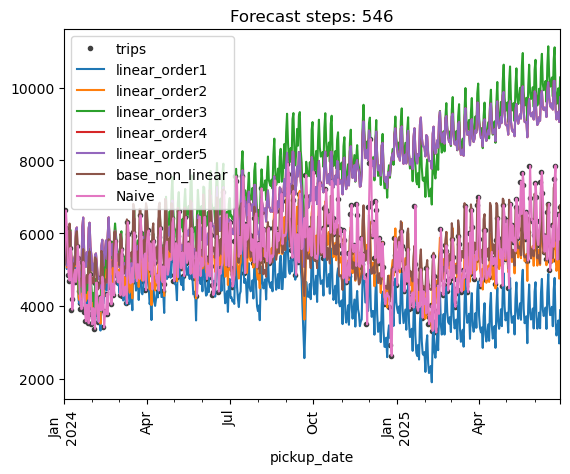

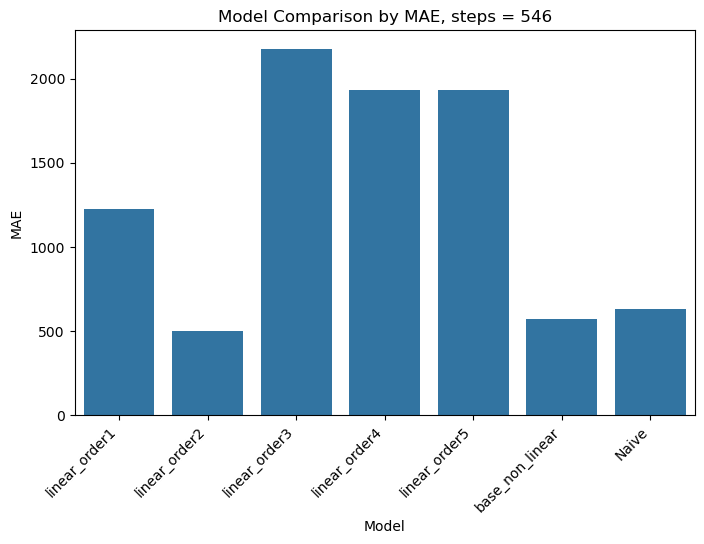

0

In [42]:
# Run forecasts
run_forecasts(steps, daily_lags, linear_models_loaded, non_linear_models_loaded, True, "D", ts_daily_train, ts_daily_test)

In the above linear_orderx is a linear model on the deterministic process + lags with weekly and yearly fourier features, where x is the order of the trend (1 linear, 2 quadratic etc). Base_non_linear is just XGBoost on deteriministic process (same fourier features) and lags. Naive is just a lag of 1, so it estimates that the current taxi count is yesterdays taxi count. 

The key observation is that although linear_order_1 performs well initally linear_order_2 is superior in the end with the best MAE of 500.2 on the longest forecast of 546 steps. Looking at the bar chart suggests that a linear trend underfits and anything above a quadratic trend overfits the data (you can seee the curves diverge from the data in the graphs above). So in future we will use a quadratic trend with our linear models. It is interesting to note that a linear trend does seem to outperfrom a quadrtatic one for lower step counts <=60 but the difference is at best 50 MAE. Whereas by a forecast of 546 quadratic trend is outperforming linear by over two fold (approx 700 MAE).

We also see that XGBoost has consitently done similar to the naive base model.

We will now look into some further improvemnts. One possible improvement would be to feed the residuals of the linear model to XGBoost to try and capture some of the more random noise in the data. 

In [48]:
# Create models and forecasts for daily ts

# 181 days in 2025 in the data, meaning 546 is the max number of steps we can forecast

# Steps for the forecast
steps = [1, 2, 3, 7, 14, 28, 30, 60, 180, 365, 500, 546]

# Fourier features (yearly and weekly)
fourier_features = ["YE", "W"]


In [49]:
# Create non linear design and traget matricies
(X_non_linear, y_non_linear, dp_non_linear) = preprocess(daily_lags, False, 0, fourier_features, "D", ts_daily_train)

# Store non linear design matricies
non_linear_design = {
    "base_non_linear": (X_non_linear, y_non_linear, dp_non_linear)
}

hybrid_design = {}

# Create linear design and target matricies 
for i in [1,2]:
    (X,y, dp_linear) = preprocess(daily_lags, True, i, fourier_features, "D", ts_daily_train)
    hybrid_design[f"hybrid_order{i}"] = (X,y,dp_linear)




In [51]:
# Train models
non_linear_models = {}
hybrid_models = {}


for key, value in non_linear_design.items():
    non_linear_models[key] = (fit_non_linear(value[0], value[1]), value[2], None)

for key, value in hybrid_design.items():

    # Fit XGBoost to residuals
    model = fit_linear(value[0],value[1])
    y_fit = model.predict(value[0])
    y_resid = value[1] - y_fit
    
    non_linear_model = fit_non_linear(value[0], y_resid)

    # Instead of None we pass the hybrid model, read src/jfk_taxis/forecast_helpers.py to see why
    hybrid_models[key] = (model, value[2], non_linear_model)


In [52]:
# Save models
for key, value in hybrid_models.items():
    joblib.dump(value[0], f"{key}.pkl")
    joblib.dump(value[1], f"{key}_dp.pkl")
    joblib.dump(value[2], f"{key}_hybrid.pkl")

for key, value in non_linear_models.items():
    joblib.dump(value[0], f"{key}.pkl")
    joblib.dump(value[1], f"{key}_dp.pkl")
    joblib.dump(value[2], f"{key}_hybrid.pkl")

# Save the keys so we can reload easily
joblib.dump(list(hybrid_models.keys()), f"hybrid_keys.pkl")
joblib.dump(list(non_linear_models.keys()), f"Non_linear_keys.pkl")



['Non_linear_keys.pkl']

In [6]:
# Load models
hybrid_keys = joblib.load("hybrid_keys.pkl")
non_linear_keys = joblib.load("Non_linear_keys.pkl")

# Create separate load dicts to avoid contamination when running cells out of order
non_linear_models_loaded = {}
hybrid_models_loaded = {}


for key in hybrid_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    hybrid_models_loaded[key] = (model, dp, hybrid)

for key in non_linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    non_linear_models_loaded[key] = (model, dp, hybrid)
   

MAE Linear: 282.24 for step = 1, model = hybrid_order1
MAE Linear: 328.10 for step = 1, model = hybrid_order2
MAE Non Linear: 225.98 for step = 1, model = base_non_linear
Naive MAE: MAE = 342.00



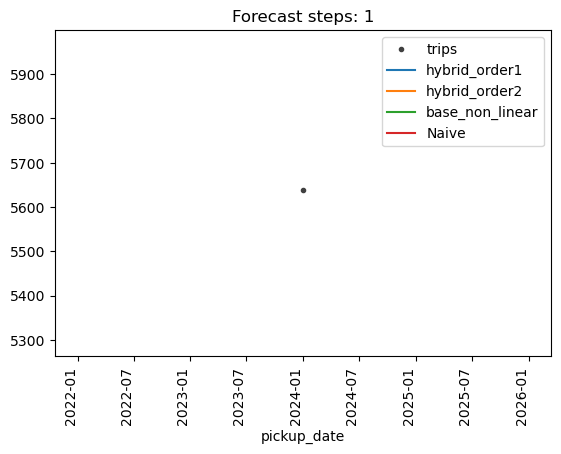

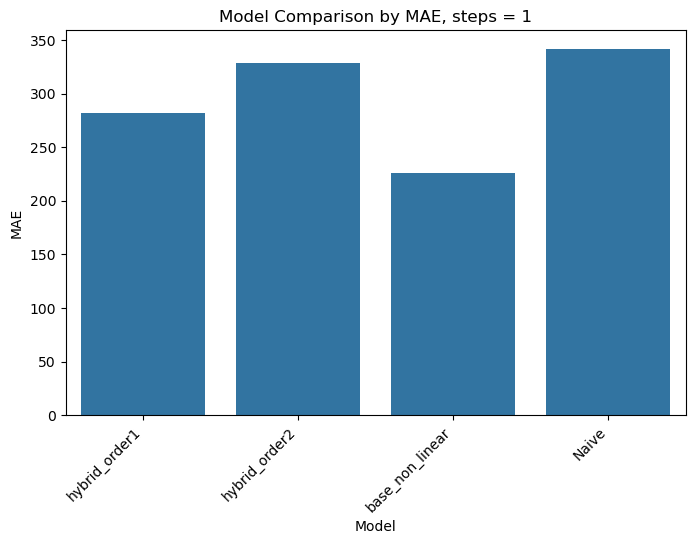

MAE Linear: 441.00 for step = 2, model = hybrid_order1
MAE Linear: 445.43 for step = 2, model = hybrid_order2
MAE Non Linear: 433.53 for step = 2, model = base_non_linear
Naive MAE: MAE = 664.00



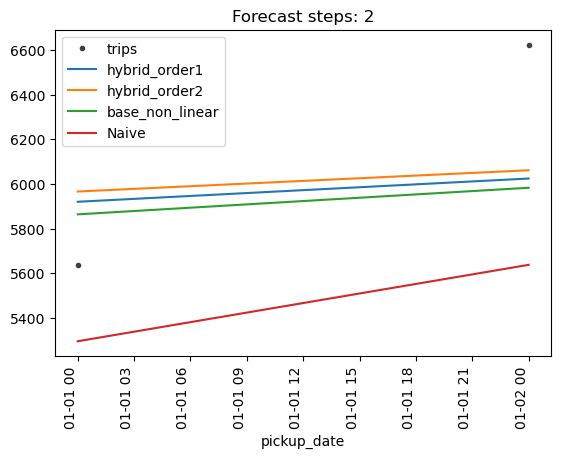

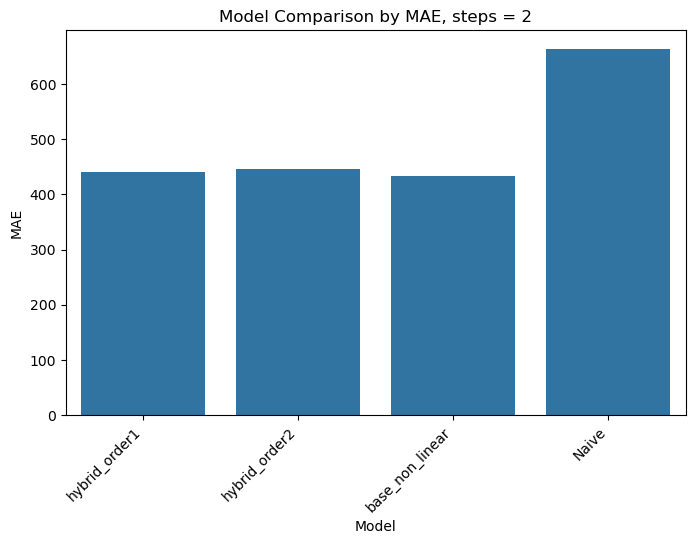

MAE Linear: 415.48 for step = 3, model = hybrid_order1
MAE Linear: 334.45 for step = 3, model = hybrid_order2
MAE Non Linear: 352.10 for step = 3, model = base_non_linear
Naive MAE: MAE = 604.33



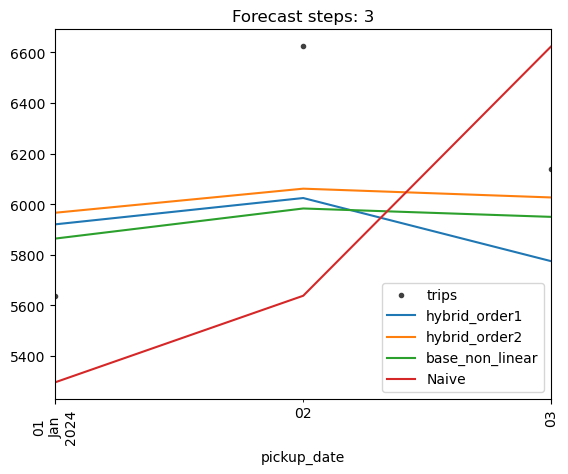

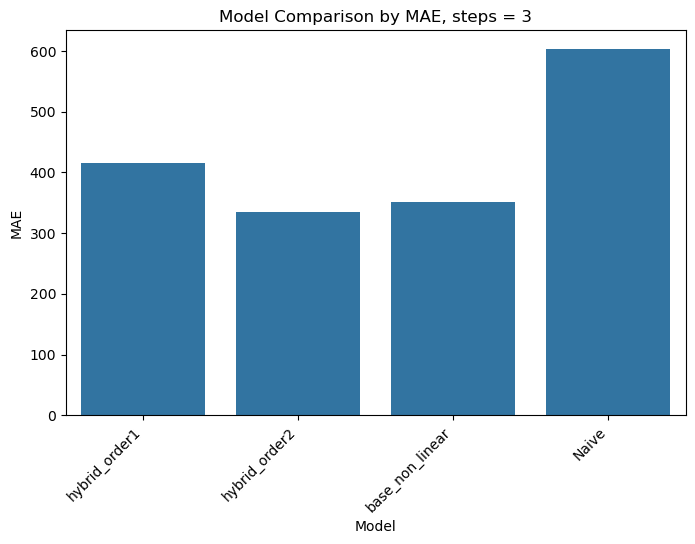

MAE Linear: 277.30 for step = 7, model = hybrid_order1
MAE Linear: 257.66 for step = 7, model = hybrid_order2
MAE Non Linear: 361.43 for step = 7, model = base_non_linear
Naive MAE: MAE = 592.71



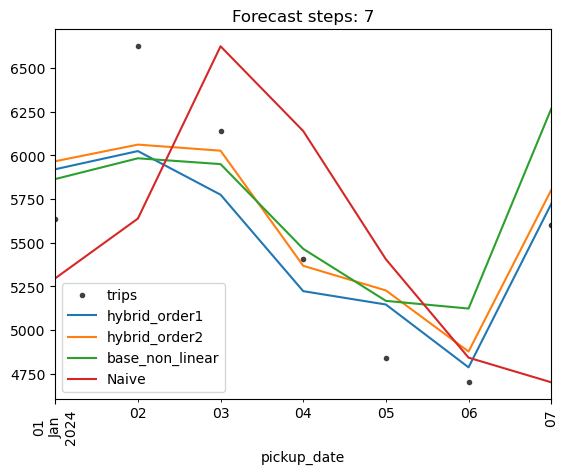

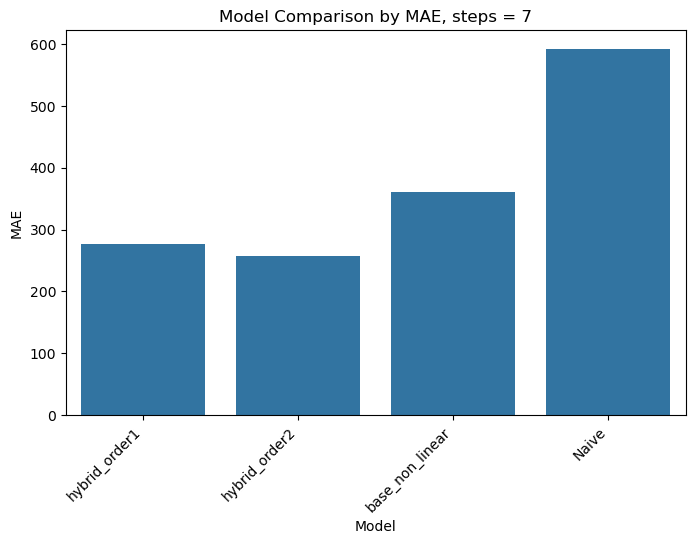

MAE Linear: 331.87 for step = 14, model = hybrid_order1
MAE Linear: 377.20 for step = 14, model = hybrid_order2
MAE Non Linear: 483.97 for step = 14, model = base_non_linear
Naive MAE: MAE = 537.71



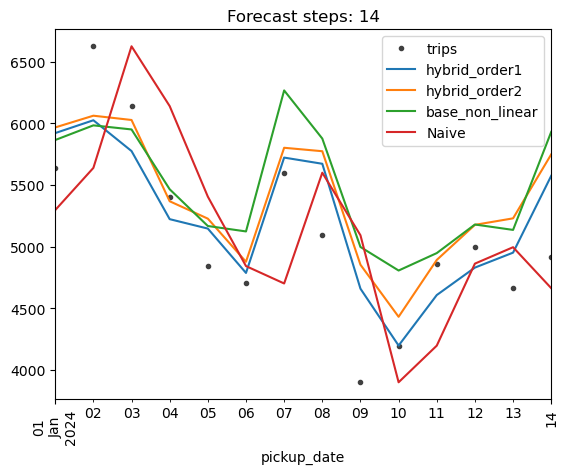

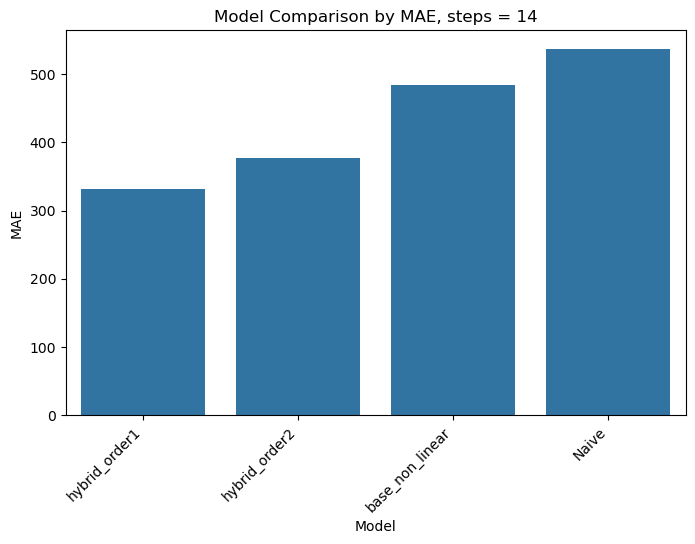

MAE Linear: 344.00 for step = 28, model = hybrid_order1
MAE Linear: 368.16 for step = 28, model = hybrid_order2
MAE Non Linear: 538.51 for step = 28, model = base_non_linear
Naive MAE: MAE = 543.11



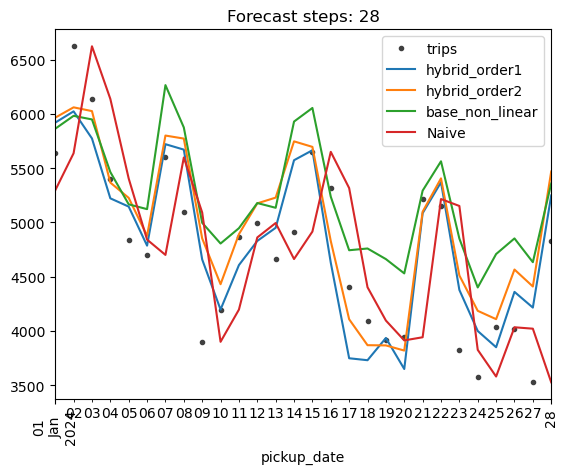

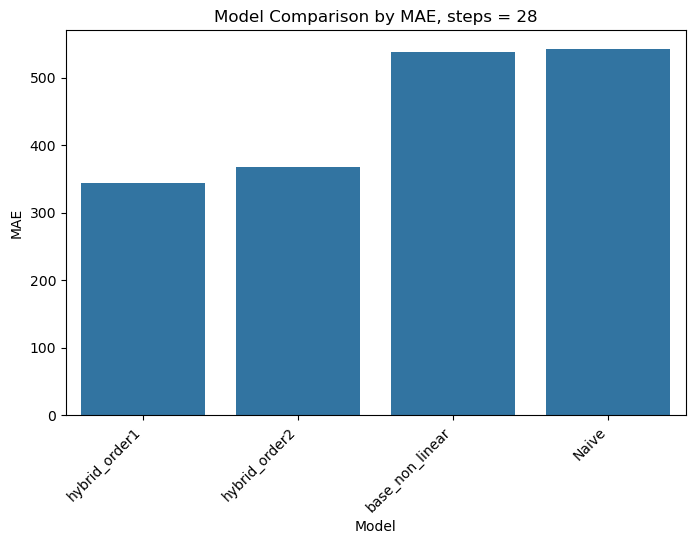

MAE Linear: 361.85 for step = 30, model = hybrid_order1
MAE Linear: 390.43 for step = 30, model = hybrid_order2
MAE Non Linear: 559.73 for step = 30, model = base_non_linear
Naive MAE: MAE = 545.37



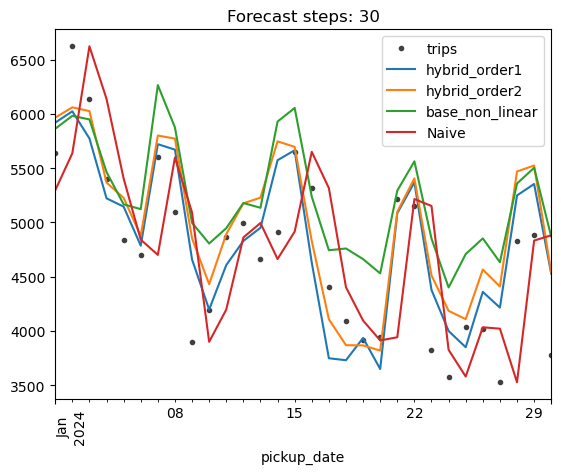

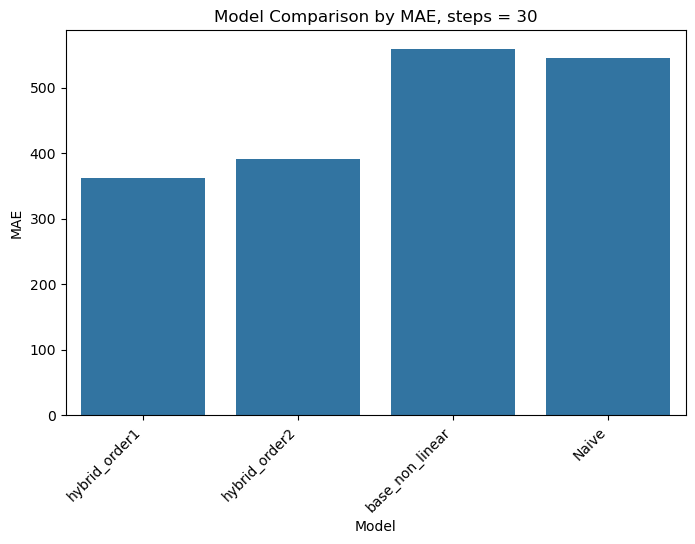

MAE Linear: 336.32 for step = 60, model = hybrid_order1
MAE Linear: 429.71 for step = 60, model = hybrid_order2
MAE Non Linear: 637.01 for step = 60, model = base_non_linear
Naive MAE: MAE = 541.90



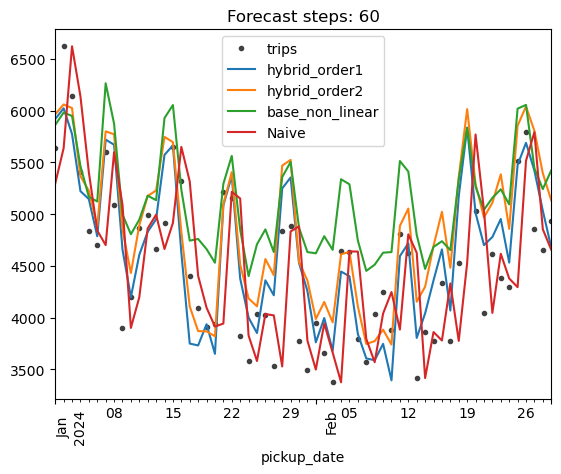

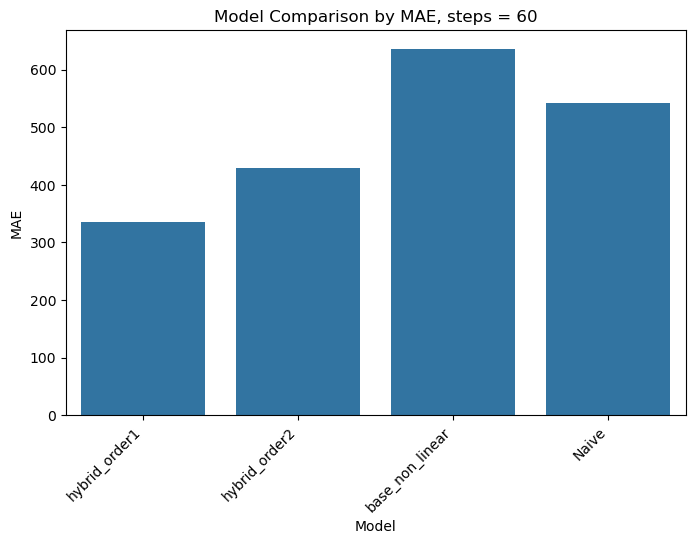

MAE Linear: 384.33 for step = 180, model = hybrid_order1
MAE Linear: 456.95 for step = 180, model = hybrid_order2
MAE Non Linear: 587.16 for step = 180, model = base_non_linear
Naive MAE: MAE = 583.99



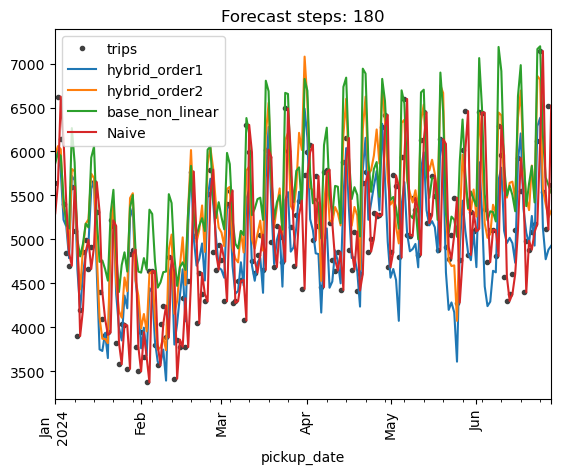

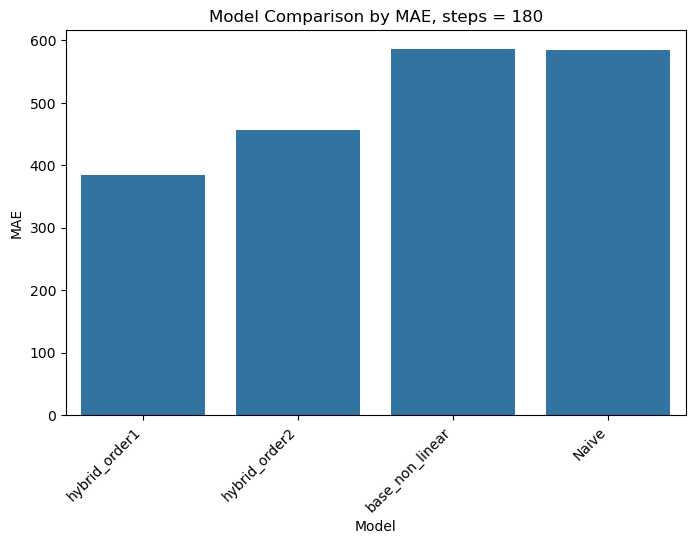

MAE Linear: 774.89 for step = 365, model = hybrid_order1
MAE Linear: 548.63 for step = 365, model = hybrid_order2
MAE Non Linear: 574.71 for step = 365, model = base_non_linear
Naive MAE: MAE = 613.42



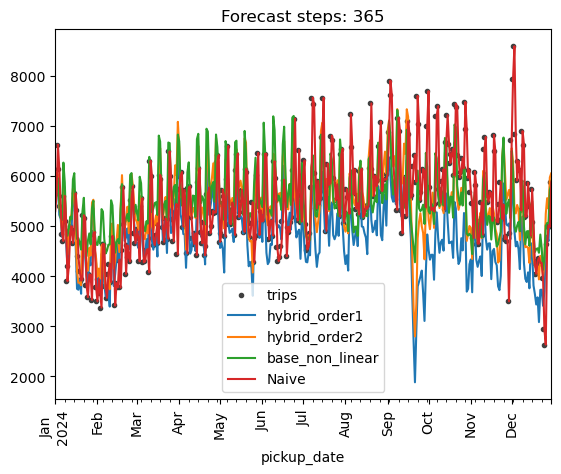

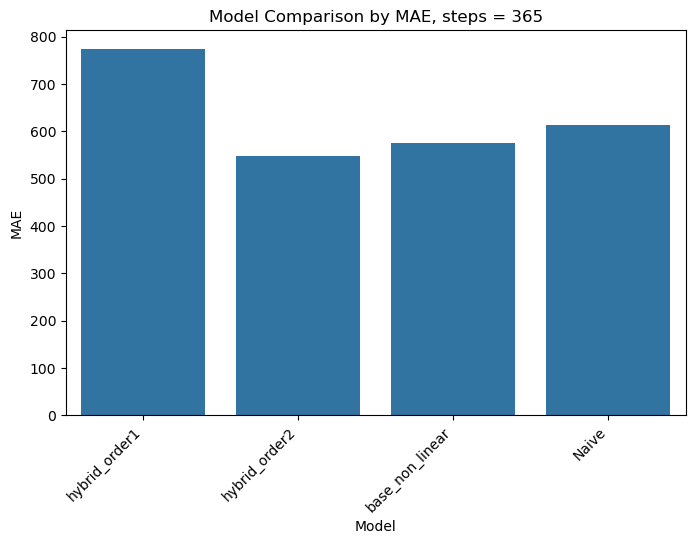

MAE Linear: 737.27 for step = 500, model = hybrid_order1
MAE Linear: 506.66 for step = 500, model = hybrid_order2
MAE Non Linear: 569.90 for step = 500, model = base_non_linear
Naive MAE: MAE = 619.86



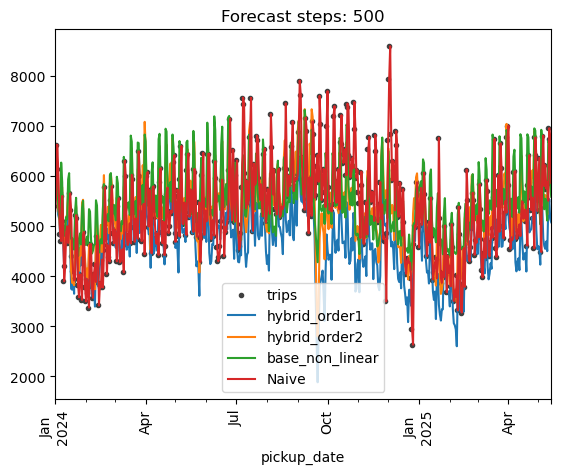

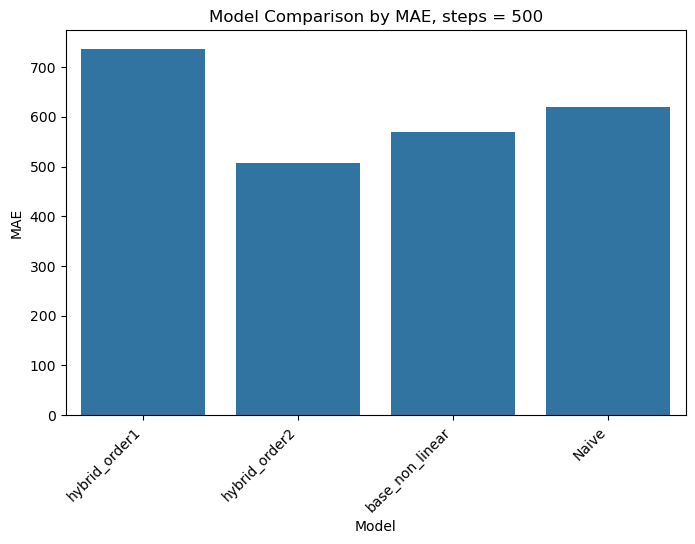

MAE Linear: 793.99 for step = 546, model = hybrid_order1
MAE Linear: 514.06 for step = 546, model = hybrid_order2
MAE Non Linear: 570.09 for step = 546, model = base_non_linear
Naive MAE: MAE = 629.36



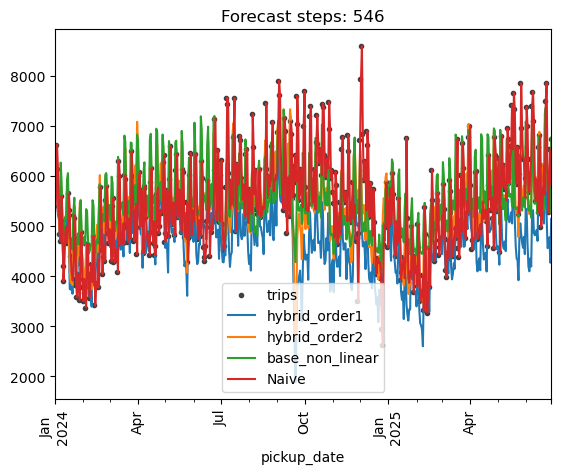

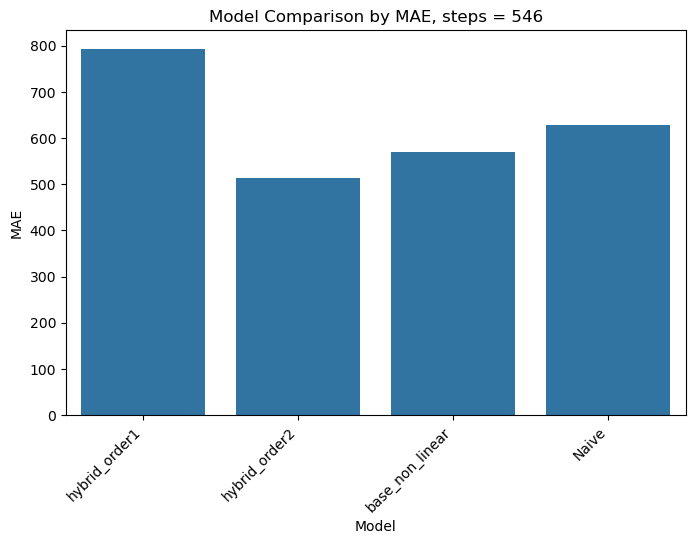

0

In [54]:
# Run forecasts
run_forecasts(steps, daily_lags, hybrid_models_loaded, non_linear_models_loaded, True, "D", ts_daily_train, ts_daily_test)

The above shows a couple intresting things, the first is we see the same pattern of hybrid_order2 again outperforming hybrid_order1 significantly long term, even if initally hybrid_order1 does slightly better.

The second is that it seems the hybrid models do slightly better on the lower step forecasts <= 60 and then worse on the higher step ones.

It's worth plotting both hybrid_order2 and linear_order2 on their own to see how they fit the data as there are a few concerining points in the above graph like just before Oct 2024 where both hybrid models make a very negative prediction that doesn't match the data. It would then also be worth plotting hybrid_order2 and linear_order2 on the same graph to see how they differ visually.

In [6]:
# Steps for the forecast
steps = [1, 2, 3, 7, 14, 28, 30, 60, 180, 365, 500, 546]


In [7]:
# Load models
hybrid_keys = joblib.load("hybrid_keys.pkl")
non_linear_keys = joblib.load("Non_linear_keys.pkl")

# Create separate load dicts to avoid contamination when running cells out of order
non_linear_models_loaded = {}
hybrid_models_loaded = {}


for key in hybrid_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    hybrid_models_loaded[key] = (model, dp, hybrid)

for key in non_linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    non_linear_models_loaded[key] = (model, dp, hybrid)
   

MAE Linear: 328.10 for step = 1, model = hybrid_order2


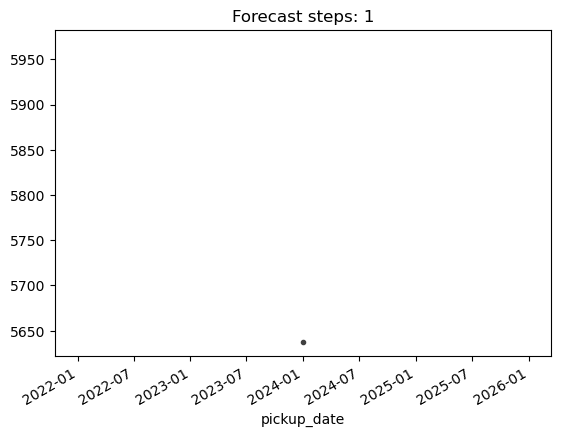

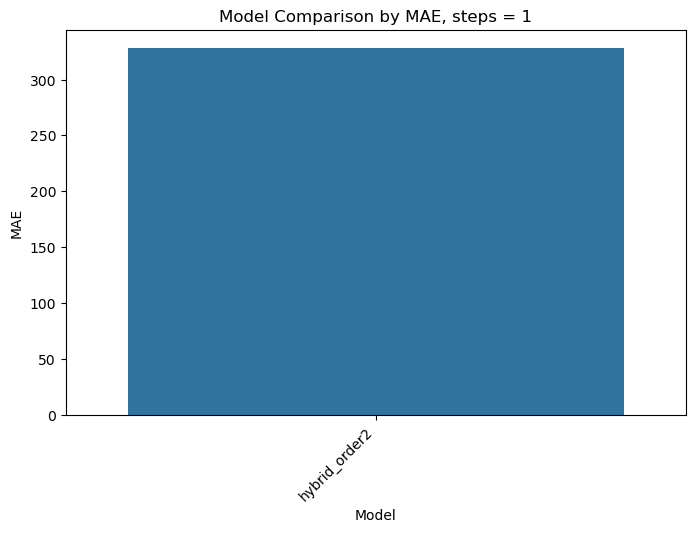

MAE Linear: 445.43 for step = 2, model = hybrid_order2


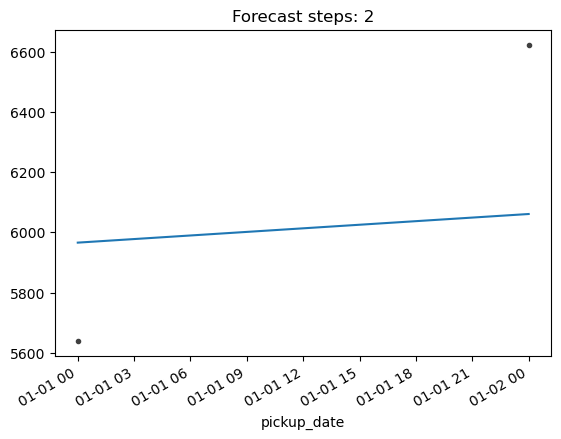

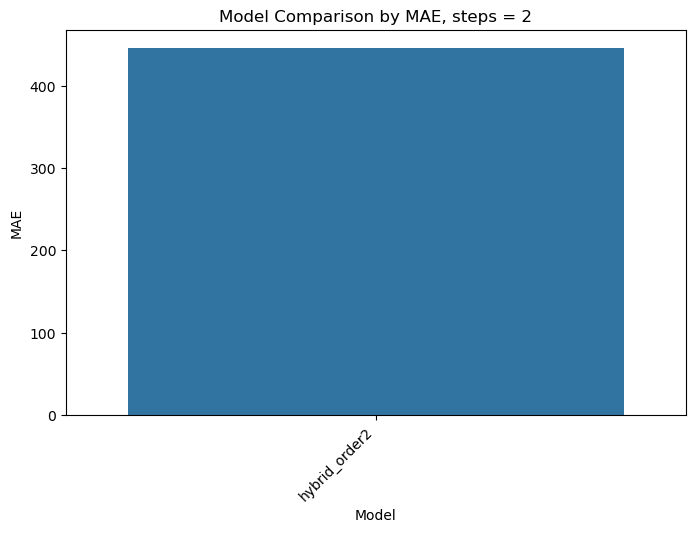

MAE Linear: 334.45 for step = 3, model = hybrid_order2


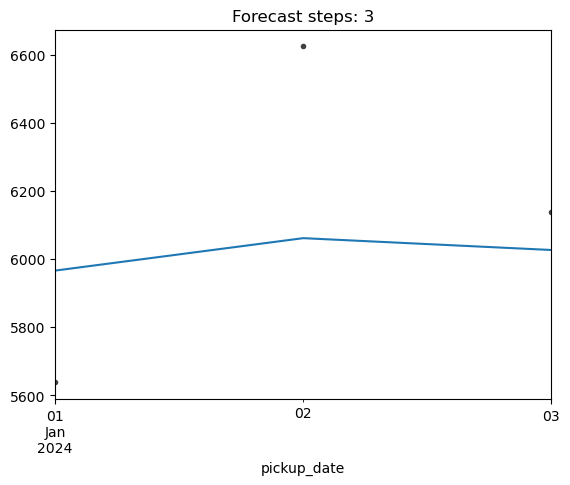

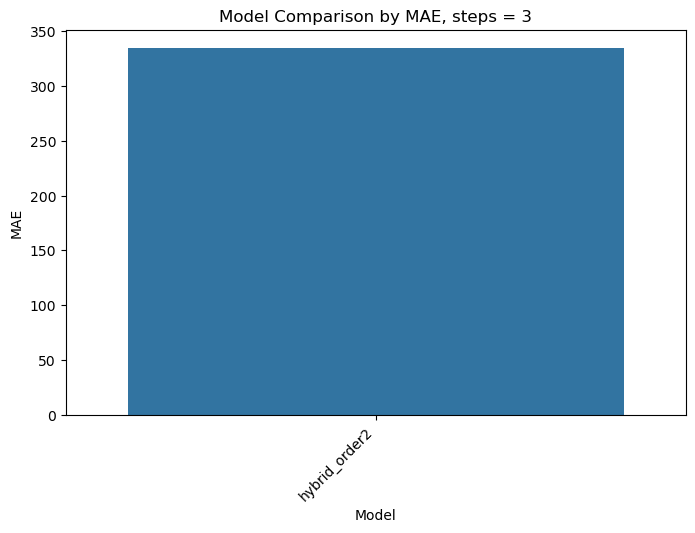

MAE Linear: 257.66 for step = 7, model = hybrid_order2


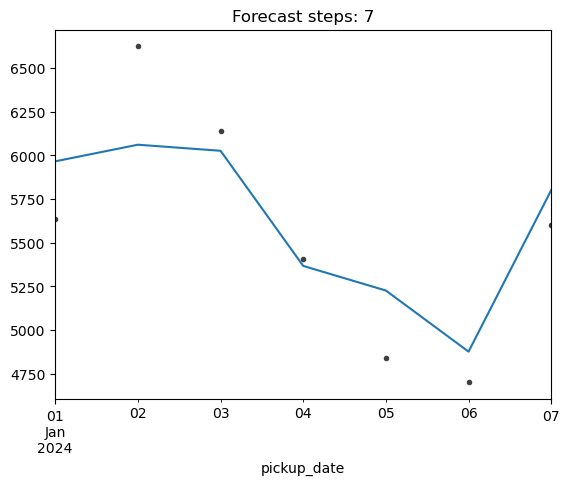

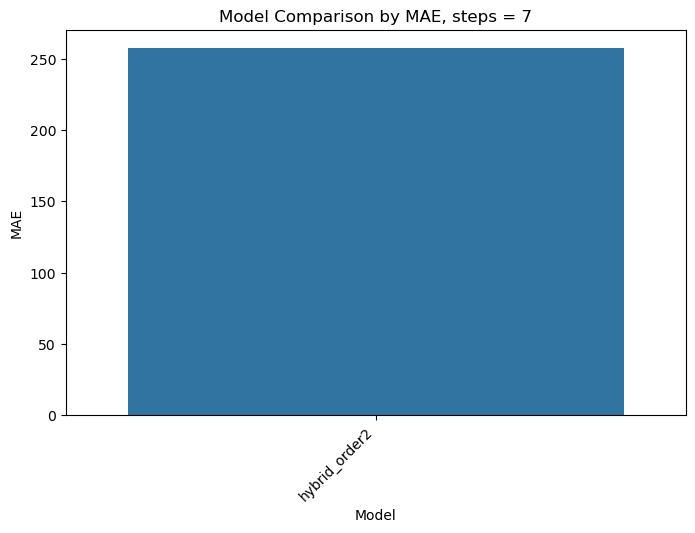

MAE Linear: 377.20 for step = 14, model = hybrid_order2


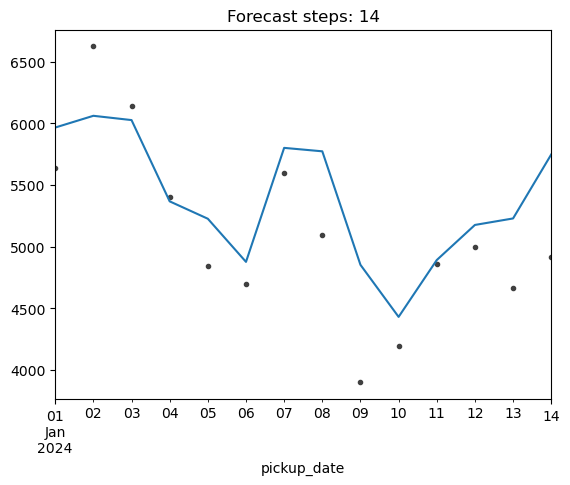

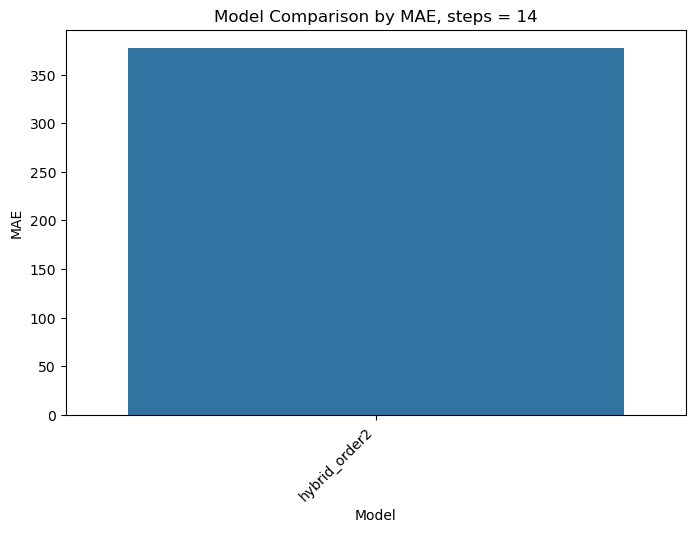

MAE Linear: 368.16 for step = 28, model = hybrid_order2


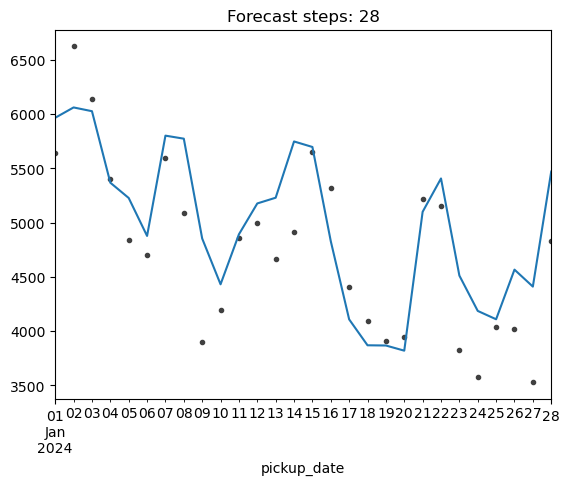

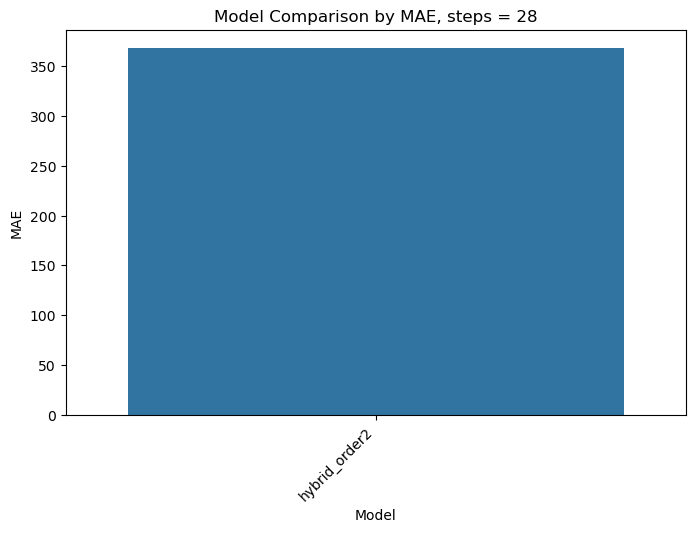

MAE Linear: 390.43 for step = 30, model = hybrid_order2


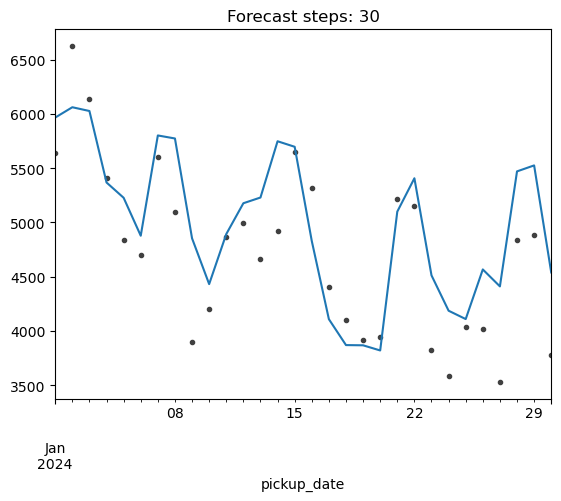

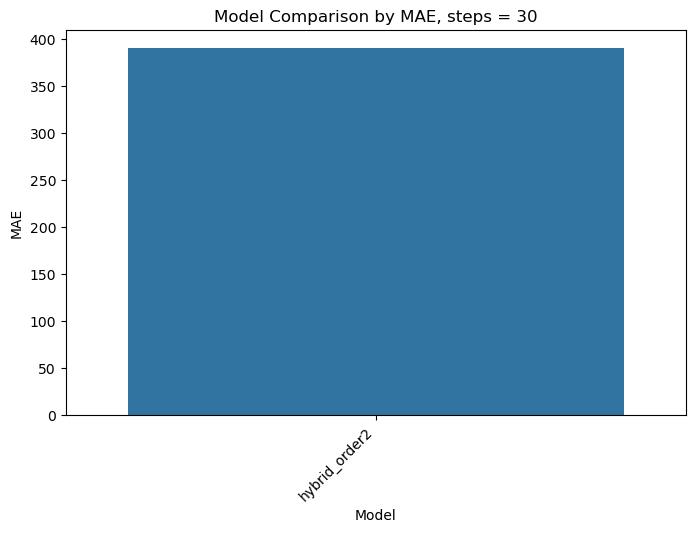

MAE Linear: 429.71 for step = 60, model = hybrid_order2


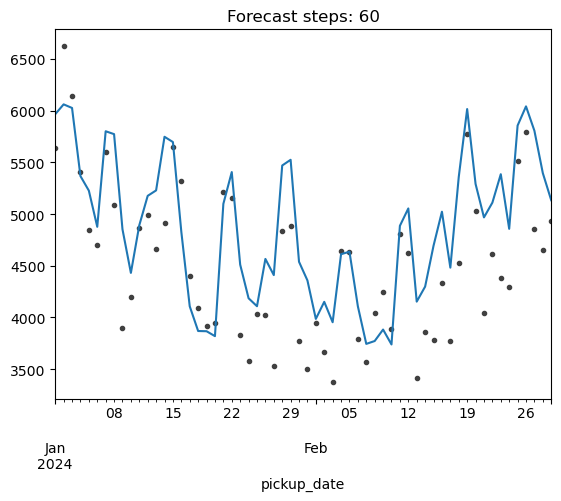

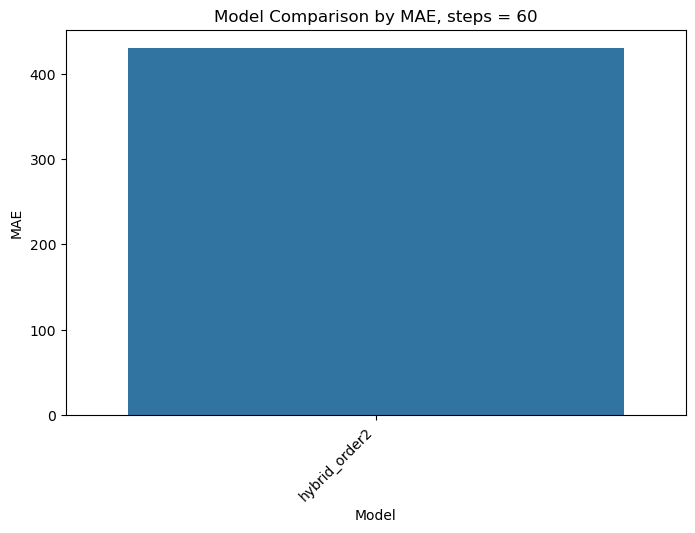

MAE Linear: 456.95 for step = 180, model = hybrid_order2


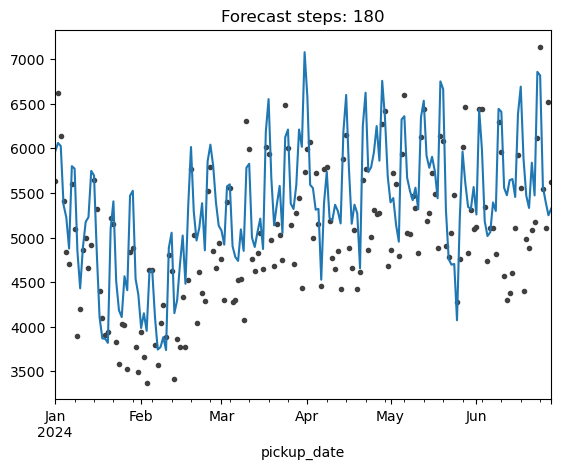

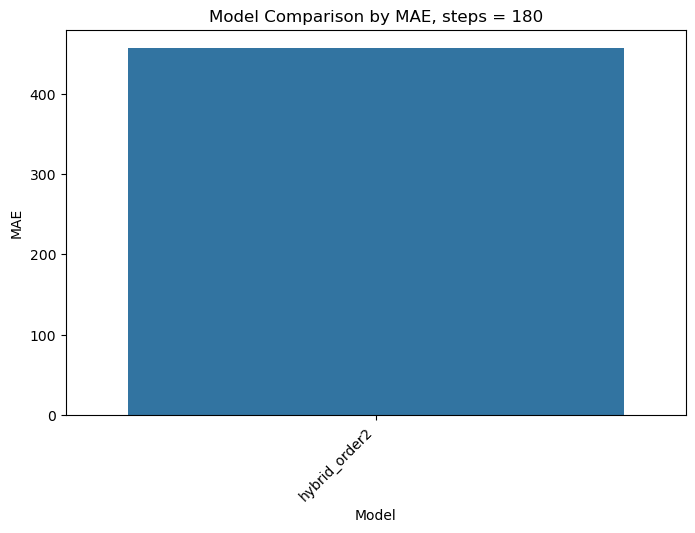

MAE Linear: 548.63 for step = 365, model = hybrid_order2


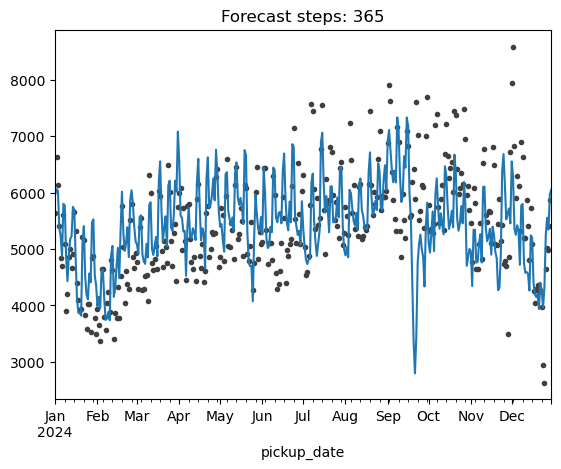

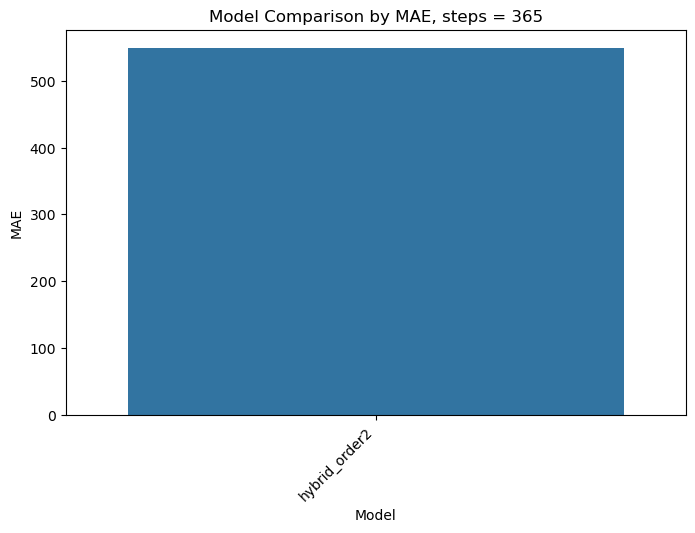

MAE Linear: 506.66 for step = 500, model = hybrid_order2


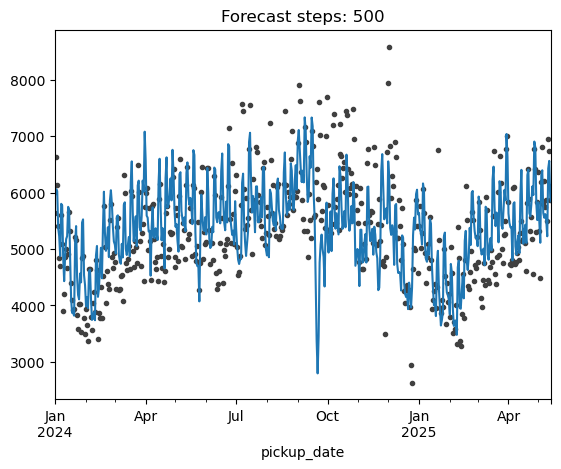

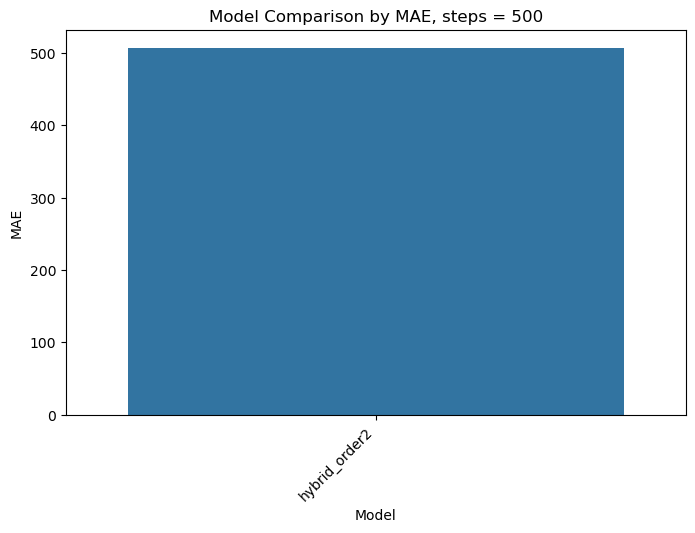

MAE Linear: 514.06 for step = 546, model = hybrid_order2


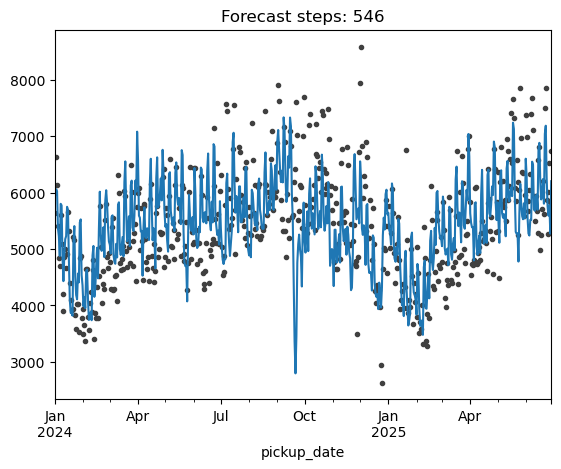

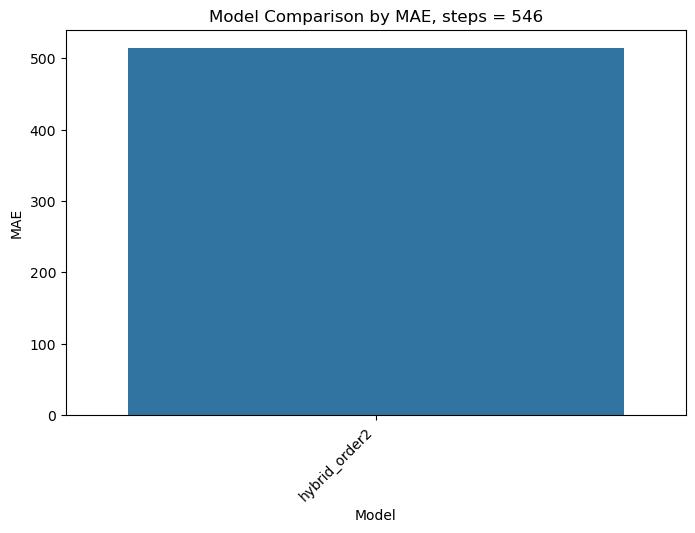

0

In [8]:
# Pop hybrid_order1
hybrid_models_loaded.pop("hybrid_order1")

# Reset non_linear dict
non_linear_models_loaded = {}

# Run forecasts, set Naive to False so we don't get a naive forecast
run_forecasts(steps, daily_lags, hybrid_models_loaded, non_linear_models_loaded, False, "D", ts_daily_train, ts_daily_test)

In [9]:
# Steps for the forecast
steps = [1, 2, 3, 7, 14, 28, 30, 60, 180, 365, 500, 546]


In [15]:
# Load models
linear_keys = joblib.load("Linear_keys.pkl")
non_linear_keys = joblib.load("Non_linear_keys.pkl")

# Create separate load dicts to avoid contamination when running cells out of order
non_linear_models_loaded = {}
linear_models_loaded = {}


for key in linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    linear_models_loaded[key] = (model, dp, hybrid)

for key in non_linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    non_linear_models_loaded[key] = (model, dp, hybrid)
   


MAE Linear: 344.90 for step = 1, model = linear_order2


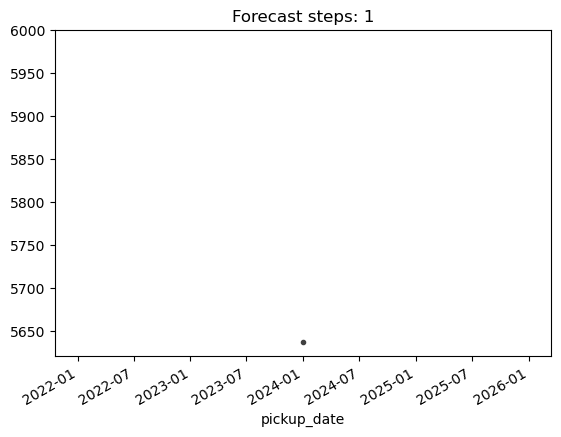

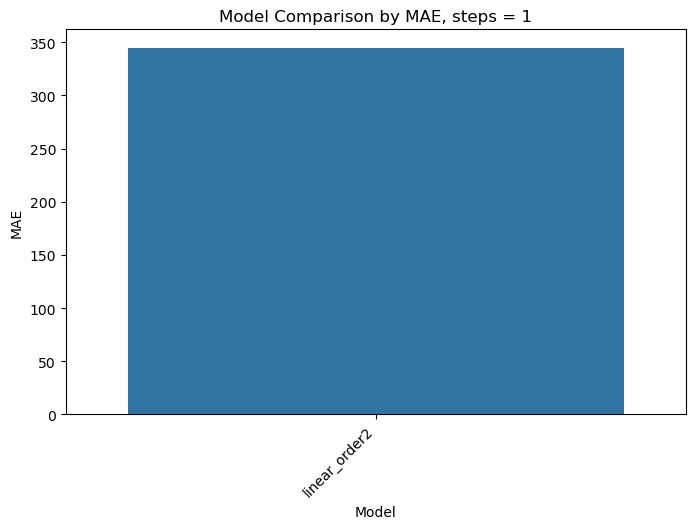

MAE Linear: 517.60 for step = 2, model = linear_order2


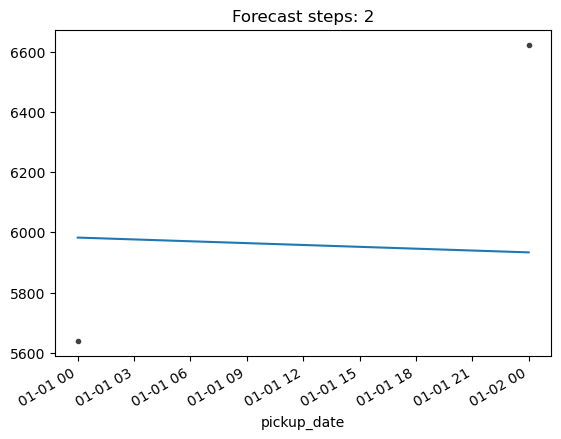

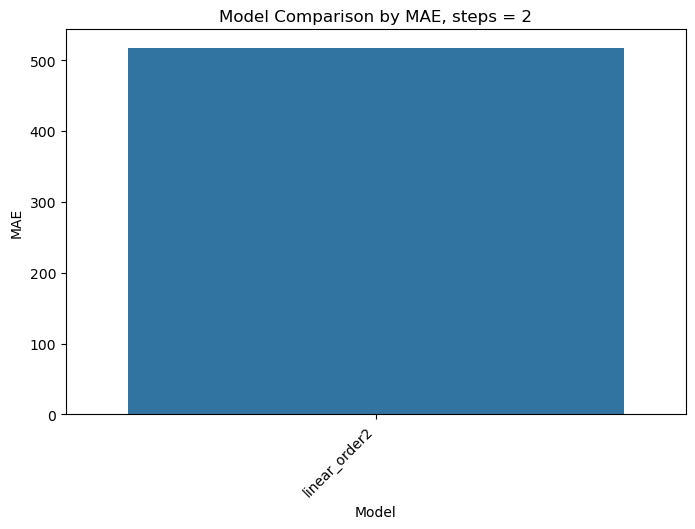

MAE Linear: 527.92 for step = 3, model = linear_order2


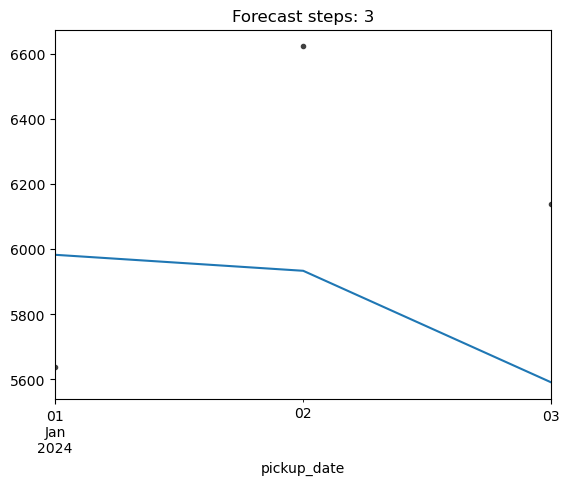

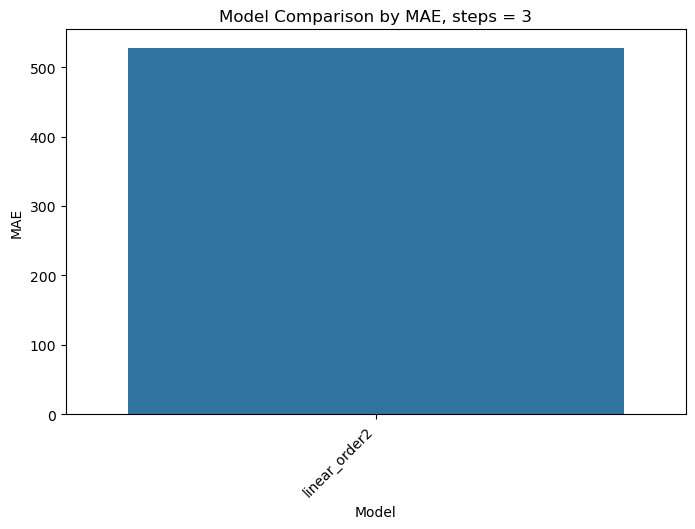

MAE Linear: 446.66 for step = 7, model = linear_order2


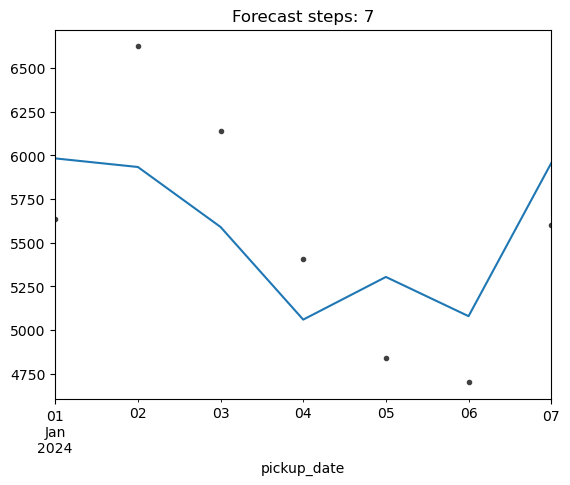

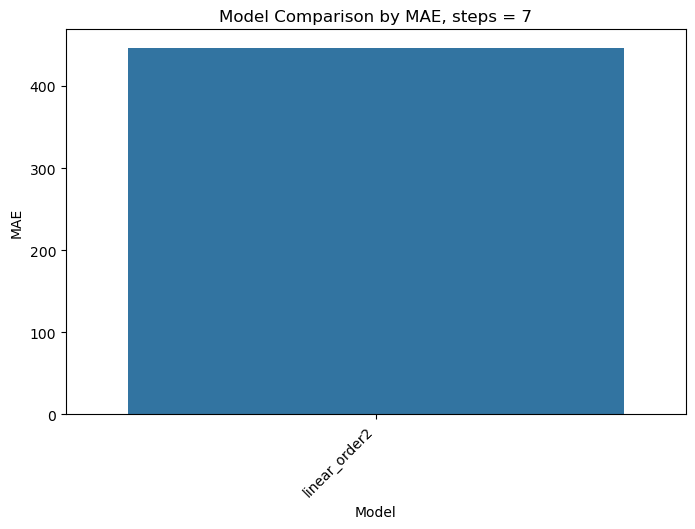

MAE Linear: 497.12 for step = 14, model = linear_order2


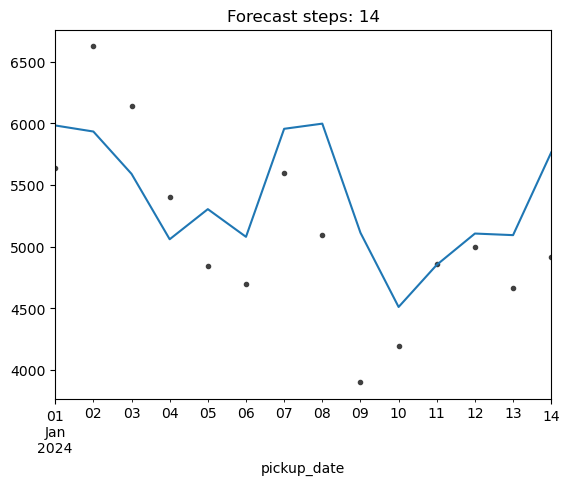

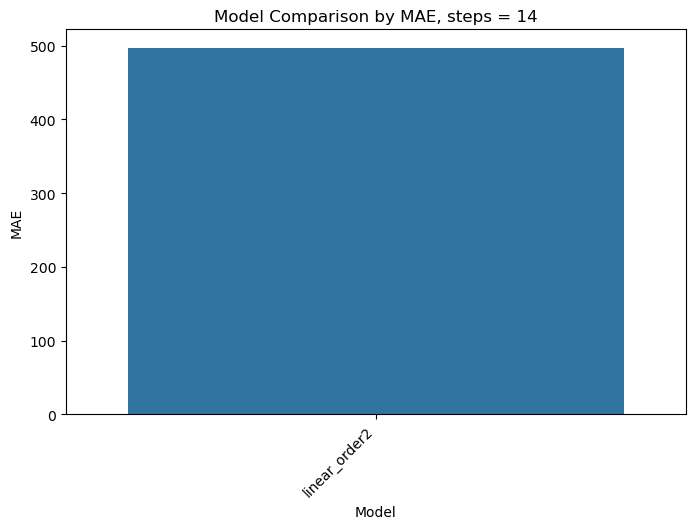

MAE Linear: 451.10 for step = 28, model = linear_order2


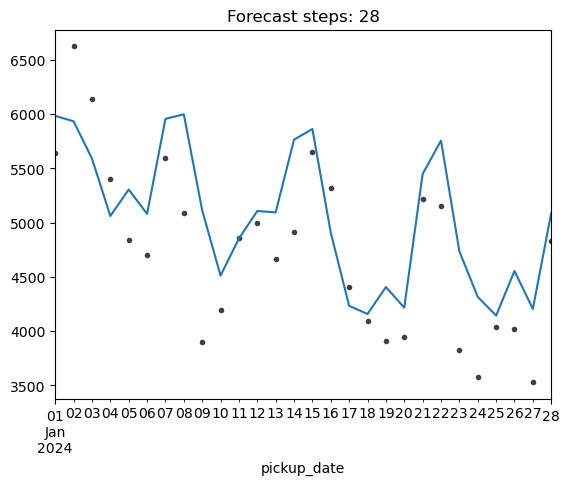

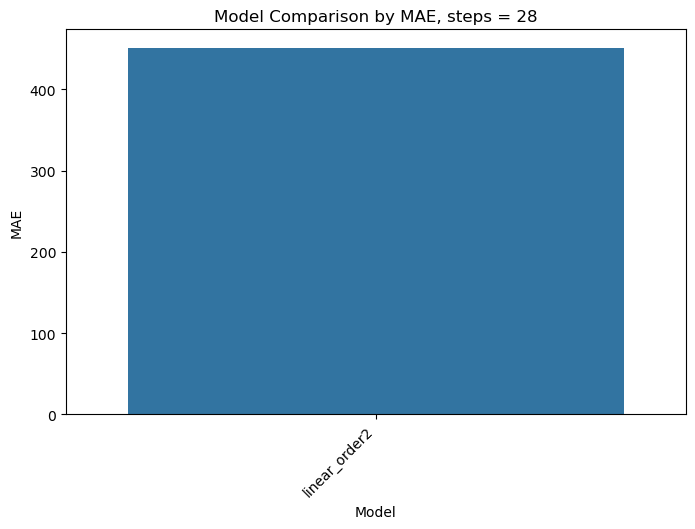

MAE Linear: 461.48 for step = 30, model = linear_order2


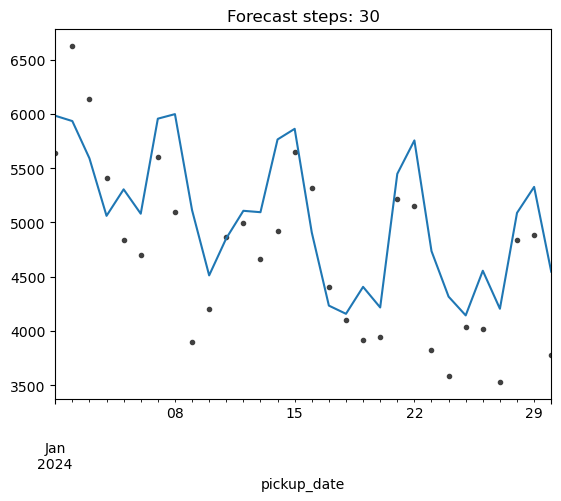

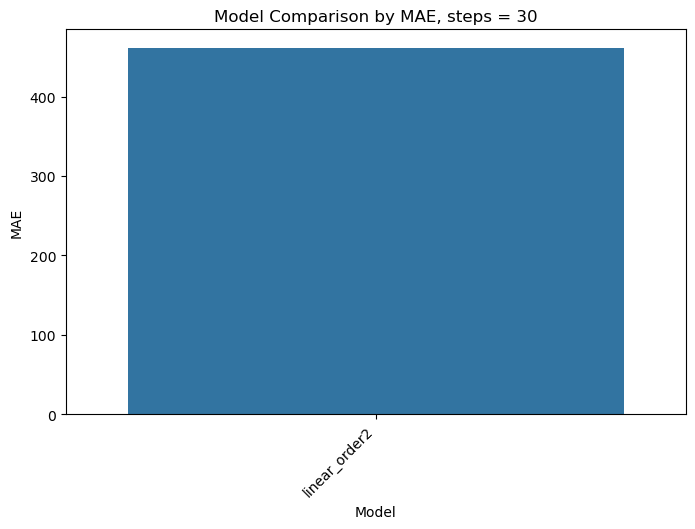

MAE Linear: 454.99 for step = 60, model = linear_order2


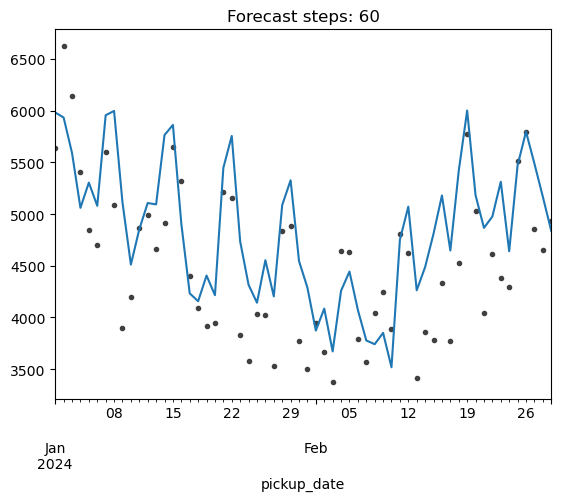

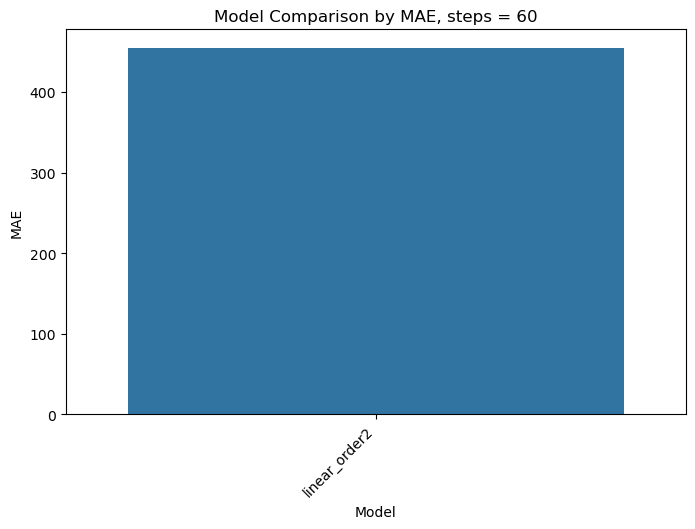

MAE Linear: 395.39 for step = 180, model = linear_order2


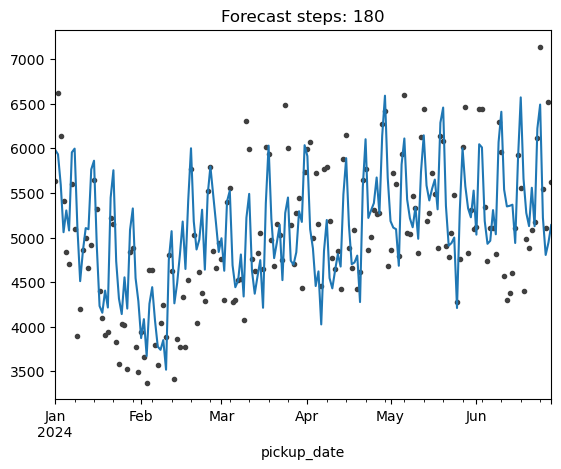

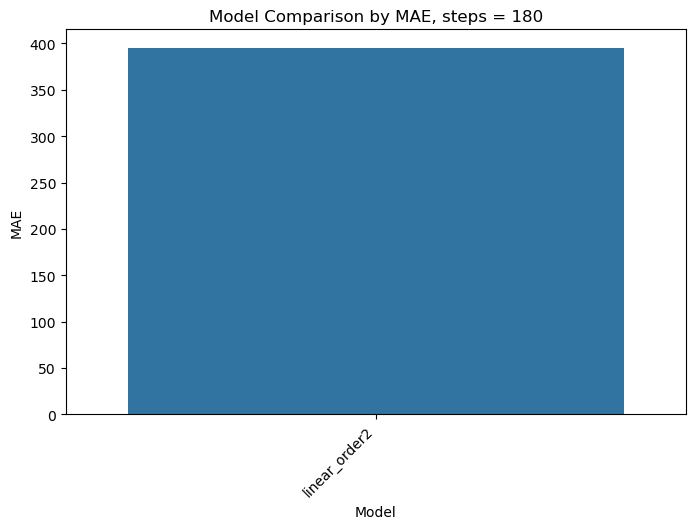

MAE Linear: 500.23 for step = 365, model = linear_order2


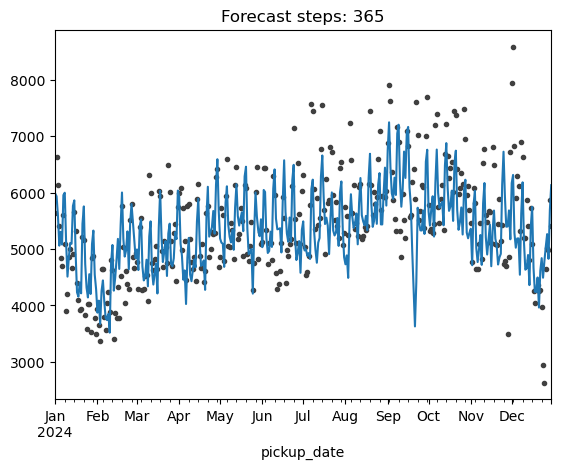

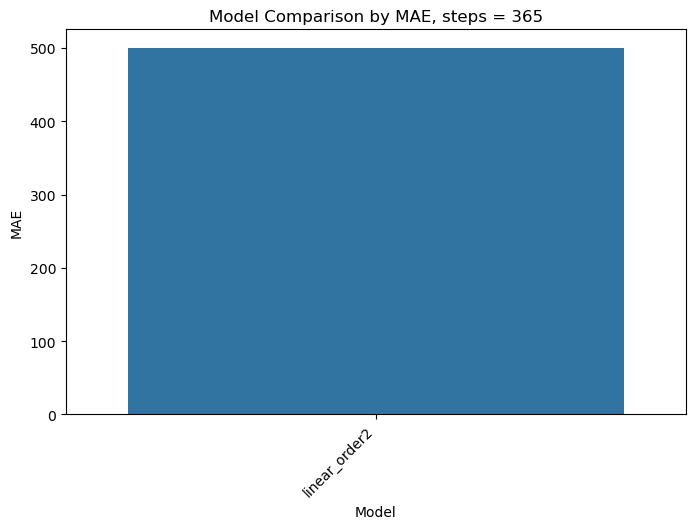

MAE Linear: 474.77 for step = 500, model = linear_order2


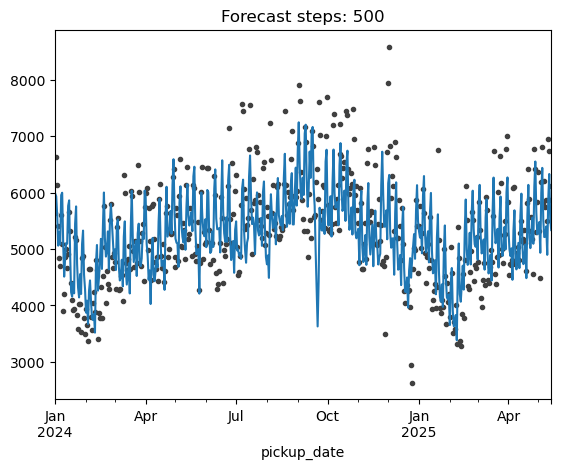

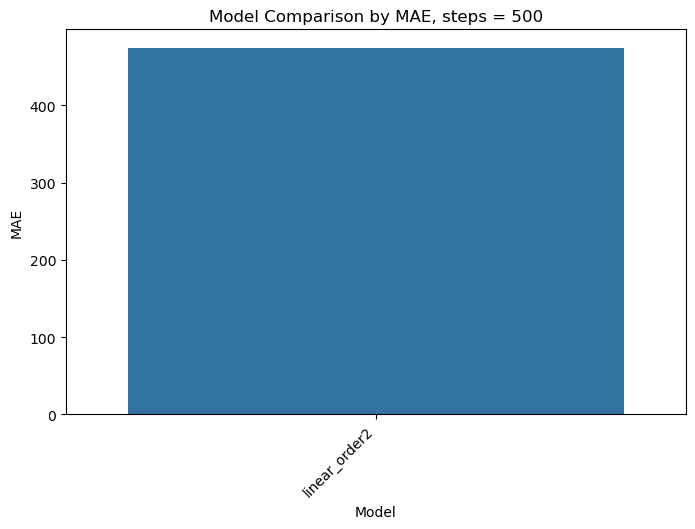

MAE Linear: 500.22 for step = 546, model = linear_order2


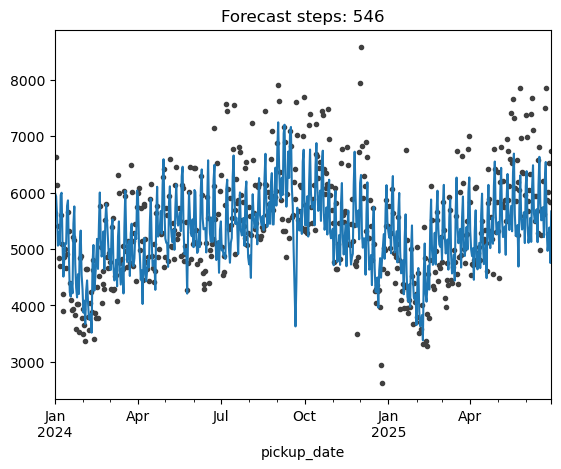

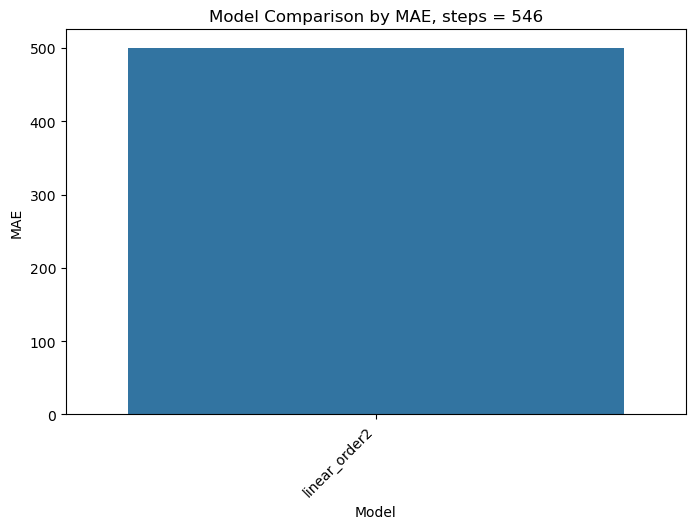

0

In [16]:
# Pop linear_order2
lo2 = linear_models_loaded.pop("linear_order2")

# Replace the dict
linear_models_loaded = {}
linear_models_loaded["linear_order2"] = lo2

# Reset non_linear dict
non_linear_models_loaded = {}

# Run forecasts, set Naive to False so we don't get a naive forecast
run_forecasts(steps, daily_lags, linear_models_loaded, non_linear_models_loaded, False, "D", ts_daily_train, ts_daily_test)

In [6]:
# Steps for the forecast
steps = [1, 2, 3, 7, 14, 28, 30, 60, 180, 365, 500, 546]


In [7]:
# Load models
linear_keys = joblib.load("Linear_keys.pkl")
non_linear_keys = joblib.load("Non_linear_keys.pkl")

# Create separate load dicts to avoid contamination when running cells out of order
non_linear_models_loaded = {}
linear_models_loaded = {}


for key in linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    linear_models_loaded[key] = (model, dp, hybrid)

for key in non_linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    non_linear_models_loaded[key] = (model, dp, hybrid)
   


In [8]:
# Load models
hybrid_keys = joblib.load("hybrid_keys.pkl")
non_linear_keys = joblib.load("Non_linear_keys.pkl")

# Create separate load dicts to avoid contamination when running cells out of order
non_linear_models_loaded = {}
hybrid_models_loaded = {}


for key in hybrid_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    hybrid_models_loaded[key] = (model, dp, hybrid)

for key in non_linear_keys:
    model = joblib.load(f"{key}.pkl")
    dp = joblib.load(f"{key}_dp.pkl")
    hybrid = joblib.load(f"{key}_hybrid.pkl")
    non_linear_models_loaded[key] = (model, dp, hybrid)

In [9]:
# Pop linear_order2
lo2 = linear_models_loaded.pop("linear_order2")

# Pop hybrid_order1
hybrid_models_loaded.pop("hybrid_order1")

# Insert linear_order2
hybrid_models_loaded["linear_order2"] = lo2

# Reset non_linear dict
non_linear_models_loaded = {}




MAE Linear: 328.10 for step = 1, model = hybrid_order2
MAE Linear: 344.90 for step = 1, model = linear_order2


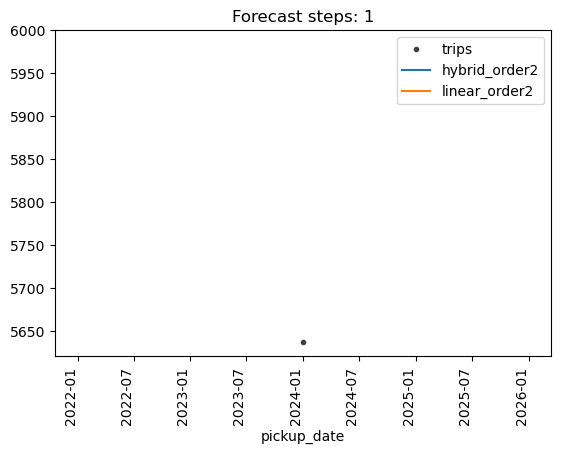

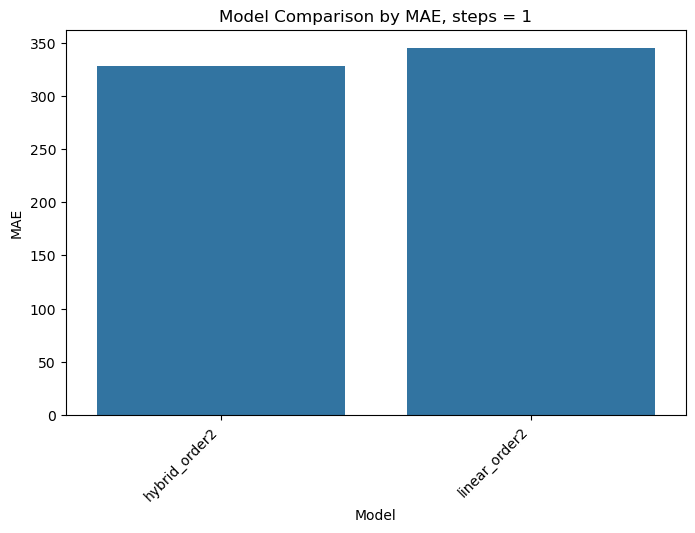

MAE Linear: 445.43 for step = 2, model = hybrid_order2
MAE Linear: 517.60 for step = 2, model = linear_order2


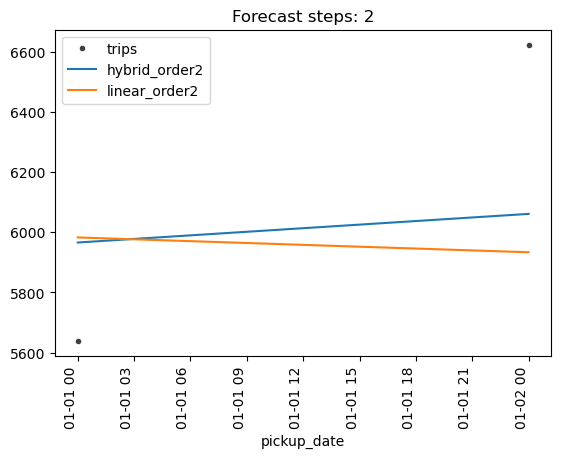

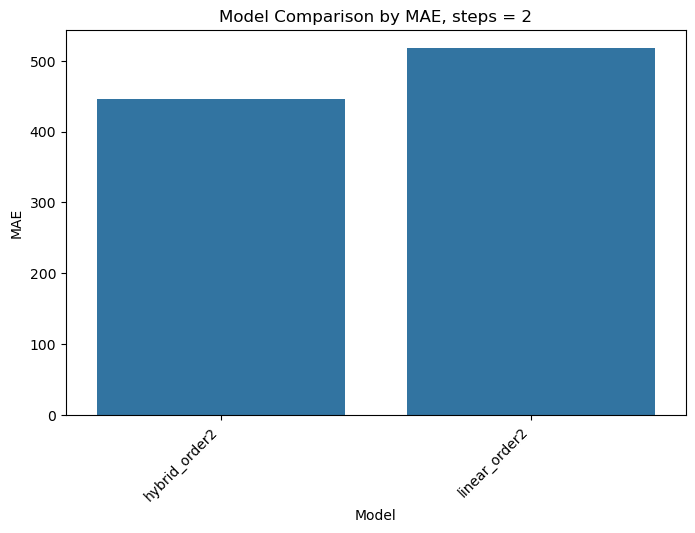

MAE Linear: 334.45 for step = 3, model = hybrid_order2
MAE Linear: 527.92 for step = 3, model = linear_order2


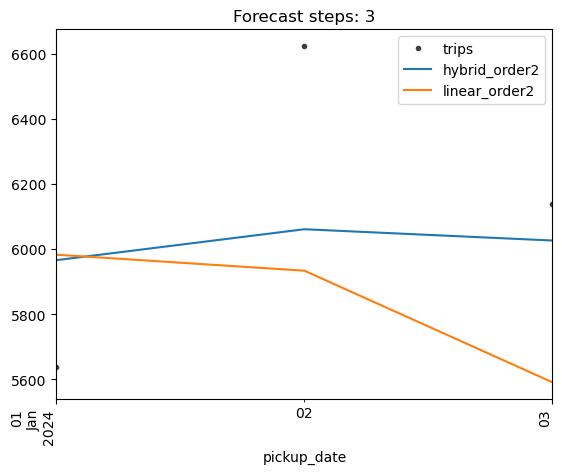

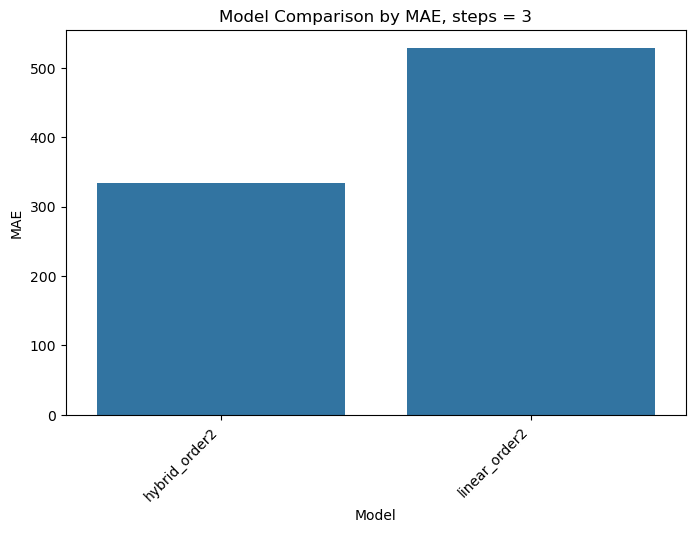

MAE Linear: 257.66 for step = 7, model = hybrid_order2
MAE Linear: 446.66 for step = 7, model = linear_order2


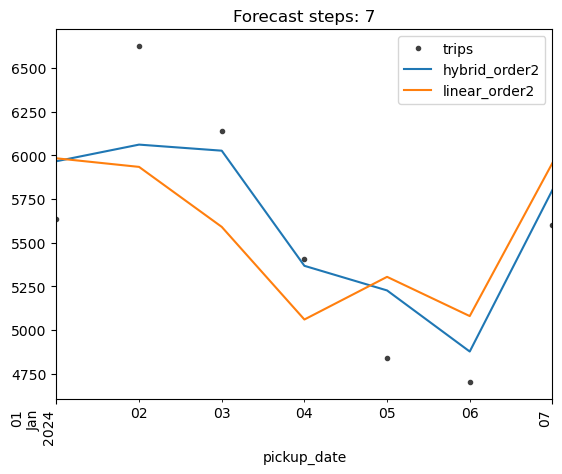

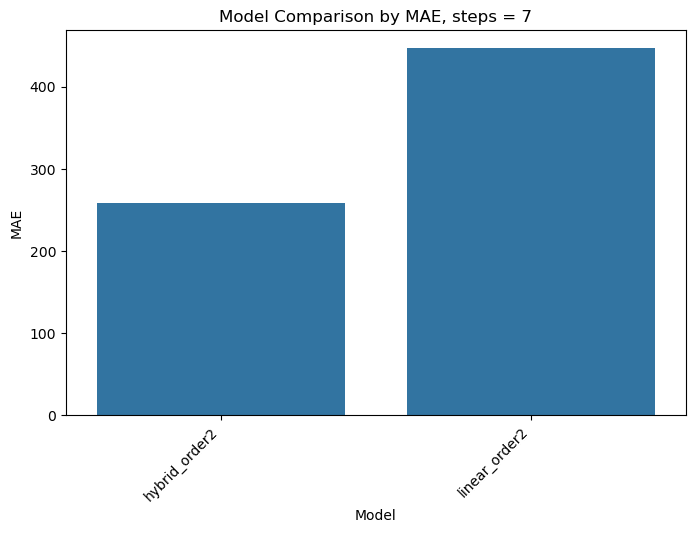

MAE Linear: 377.20 for step = 14, model = hybrid_order2
MAE Linear: 497.12 for step = 14, model = linear_order2


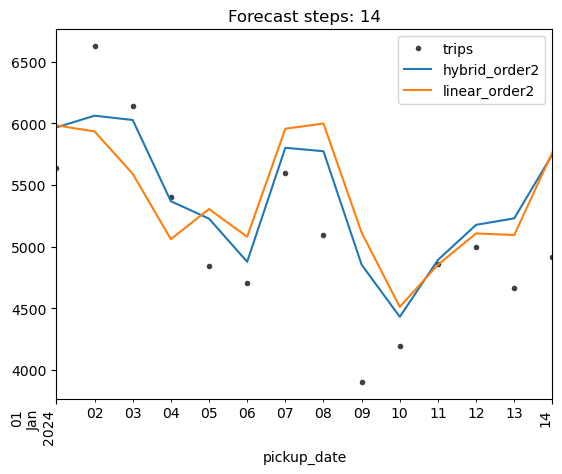

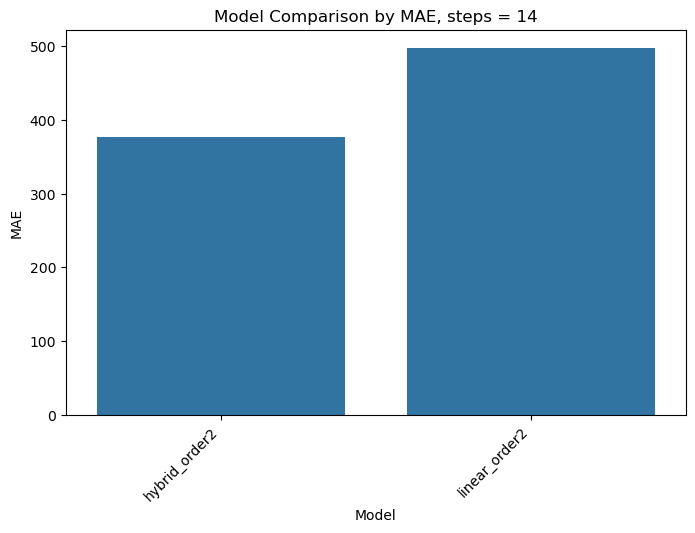

MAE Linear: 368.16 for step = 28, model = hybrid_order2
MAE Linear: 451.10 for step = 28, model = linear_order2


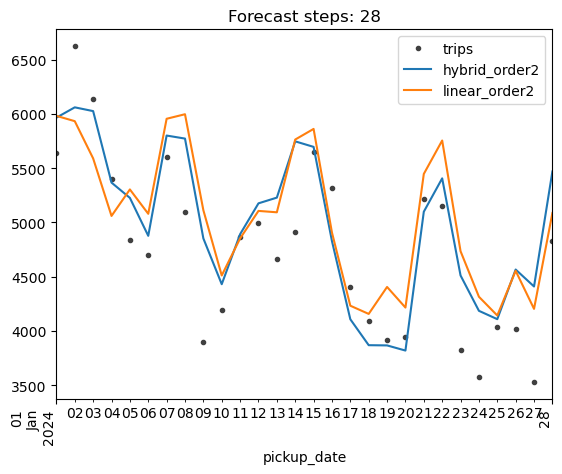

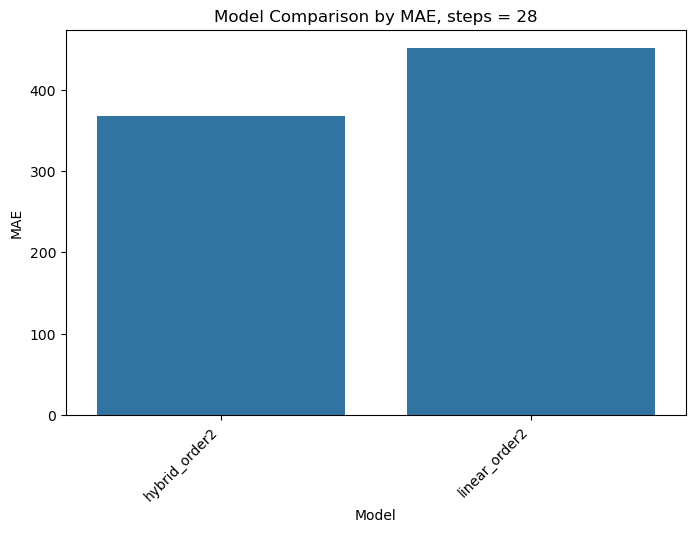

MAE Linear: 390.43 for step = 30, model = hybrid_order2
MAE Linear: 461.48 for step = 30, model = linear_order2


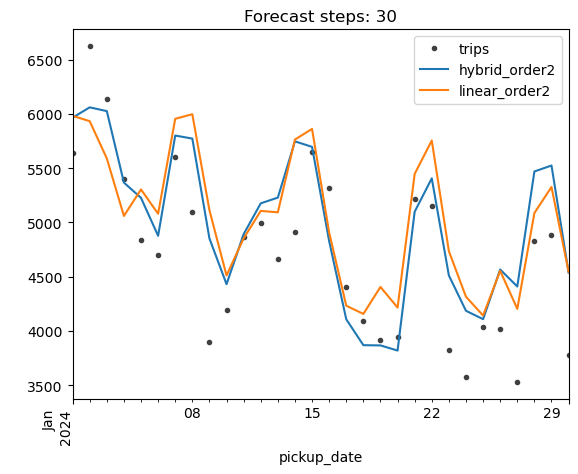

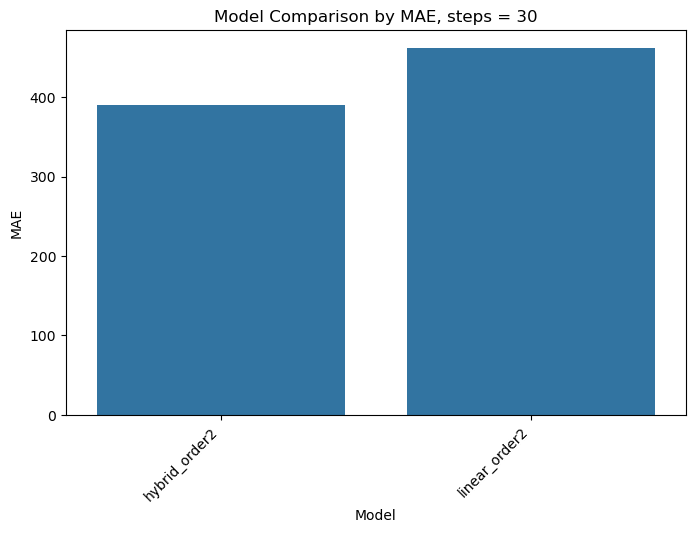

MAE Linear: 429.71 for step = 60, model = hybrid_order2
MAE Linear: 454.99 for step = 60, model = linear_order2


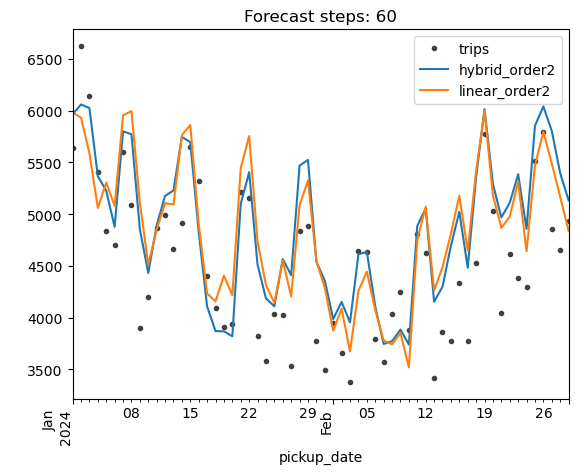

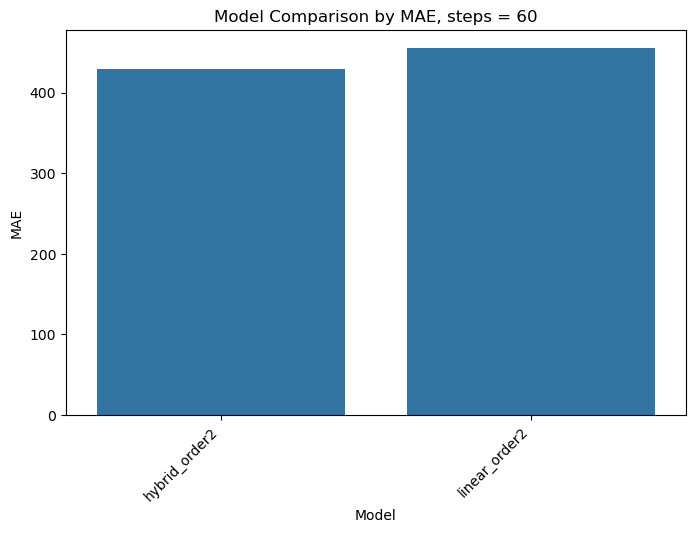

MAE Linear: 456.95 for step = 180, model = hybrid_order2
MAE Linear: 395.39 for step = 180, model = linear_order2


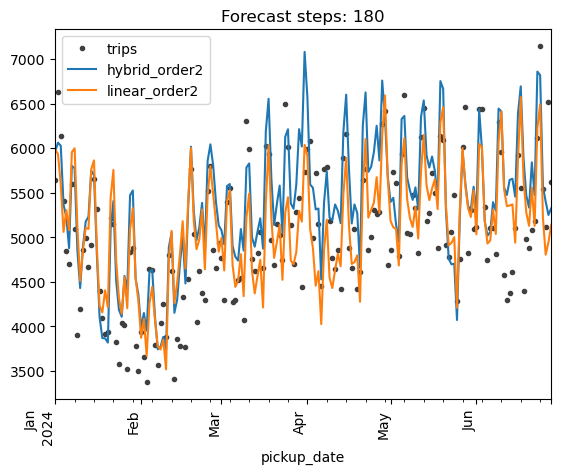

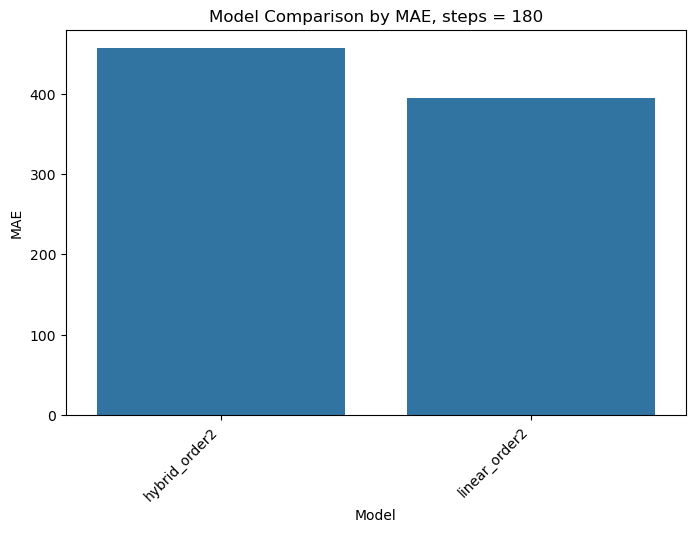

MAE Linear: 548.63 for step = 365, model = hybrid_order2
MAE Linear: 500.23 for step = 365, model = linear_order2


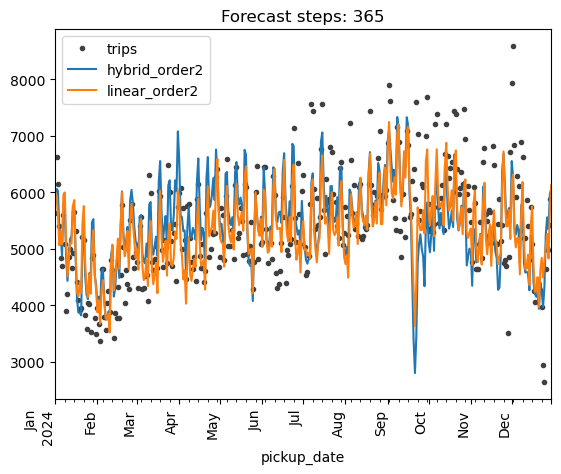

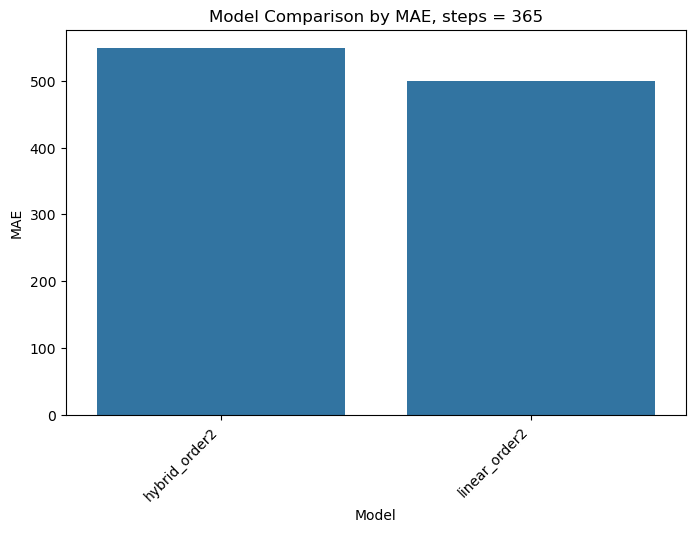

MAE Linear: 506.66 for step = 500, model = hybrid_order2
MAE Linear: 474.77 for step = 500, model = linear_order2


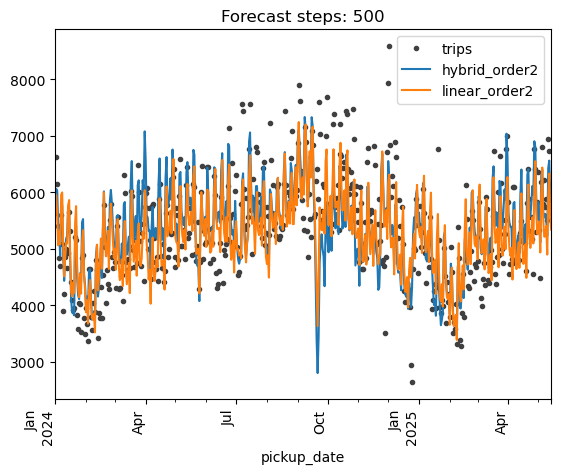

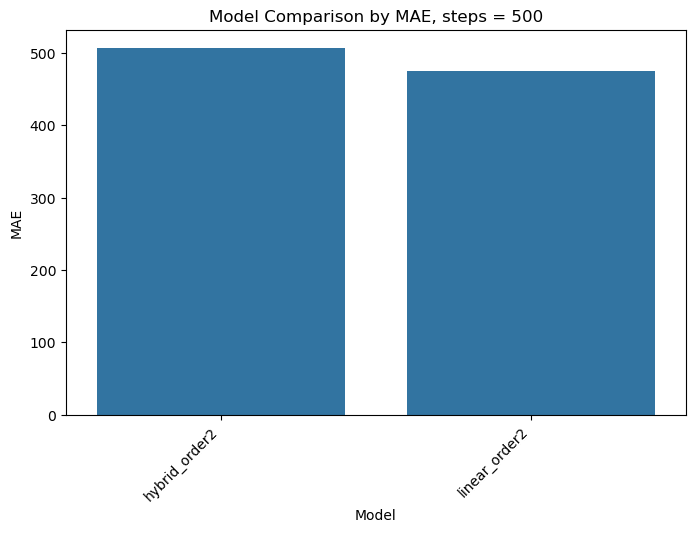

MAE Linear: 514.06 for step = 546, model = hybrid_order2
MAE Linear: 500.22 for step = 546, model = linear_order2


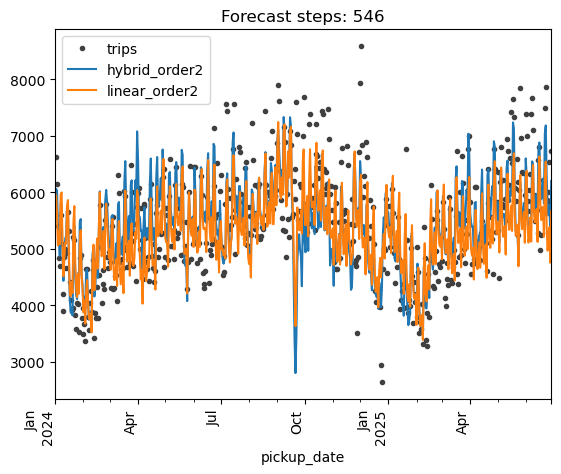

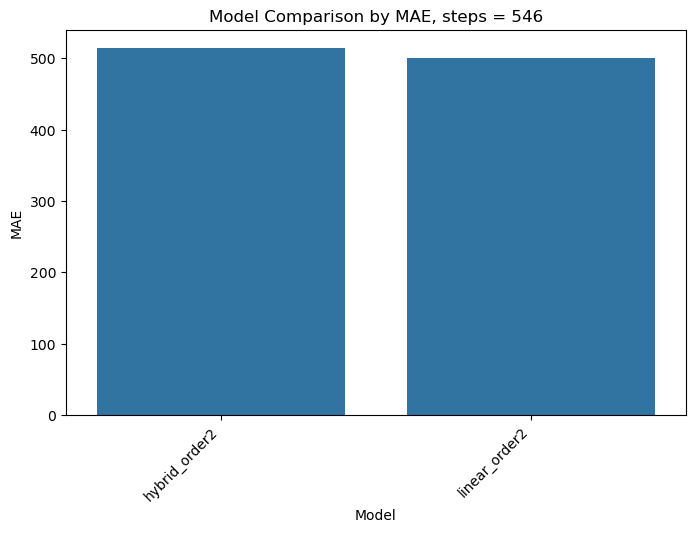

0

In [10]:

# Run forecasts, set Naive to False so we don't get a naive forecast
run_forecasts(steps, daily_lags, hybrid_models_loaded, non_linear_models_loaded, False, "D", ts_daily_train, ts_daily_test)

The above shows that both linear_order2 and hybrid_order2 are very similar. What seems to be happening is that the more extreme "error" from linear_order2 (the big downward spike before October) get exagorated by hybrid_order_2. However for short term forecasts hybrid_order2 does outperform linear_order2 which likely only overtakes slightly by the end because hybrid_order2 has more extreme errors.

This suggests that potentially with some hyperparameter tuning (the XGBoost hyperparameters are just a random setup) the model could perform a lot better which is worth exploring later.

For now we seek to repeat these experiements with the hourly time series.

In [8]:
# Create models and forecasts for hourly ts

# 181 days in 2025 in the data, meaning 13,104 is the max number of steps we can forecast

# Key step counts:
# 1 day = 24 hours
# 1 week = 168 hours
# 1 month = 720 hours (approx)
# 6 months = 4320 hours (approx)
# 1 year = 8760 hours
# 1 year + 181 days = 13104 hours

# Steps for the forecast
steps = [4, 6, 12, 24, 48, 72, 96, 120, 168, 336, 720, 4320, 8760, 13104]

# Fourier features (daily and weekly)
fourier_features = ["D", "W"]


In [10]:
# We have a slight problem in that we have so many lags it currently causes a memory error in pandas, we will try reducing this by just using the first 168 lags (for 1 week instead)
hourly_lags_used = hourly_lags[0:168]

In [10]:
# Create non linear design and traget matricies
(X_non_linear, y_non_linear, dp_non_linear) = preprocess(hourly_lags_used, False, 0, fourier_features, "h", ts_hourly_train)

# Store non linear design matricies
non_linear_design = {
    "base_non_linear": (X_non_linear, y_non_linear, dp_non_linear)
}

linear_design = {}

# Create linear design and target matricies 
for i in [1,2,3,4,5]:
    (X,y, dp_linear) = preprocess(hourly_lags_used, True, i, fourier_features, "h", ts_hourly_train)
    linear_design[f"linear_order{i}"] = (X,y,dp_linear)





In [11]:
# Train models
non_linear_models = {}
linear_models = {}


for key, value in non_linear_design.items():
    non_linear_models[key] = (fit_non_linear(value[0], value[1]), value[2], None)

for key, value in linear_design.items():
    linear_models[key] = (fit_linear(value[0], value[1]), value[2], None)



In [12]:
# Save models
for key, value in linear_models.items():
    joblib.dump(value[0], f"{key}_hour.pkl")
    joblib.dump(value[1], f"{key}_dp_hour.pkl")
    joblib.dump(value[2], f"{key}_hybrid_hour.pkl")

for key, value in non_linear_models.items():
    joblib.dump(value[0], f"{key}_hour.pkl")
    joblib.dump(value[1], f"{key}_dp_hour.pkl")
    joblib.dump(value[2], f"{key}_hybrid_hour.pkl")

# Save the keys so we can reload easily
joblib.dump(list(linear_models.keys()), f"Linear_keys_hour.pkl")
joblib.dump(list(non_linear_models.keys()), f"Non_linear_keys_hour.pkl")



['Non_linear_keys_hour.pkl']

In [6]:
# Load models
linear_keys = joblib.load("Linear_keys_hour.pkl")
non_linear_keys = joblib.load("Non_linear_keys_hour.pkl")

# Create separate load dicts to avoid contamination when running cells out of order
non_linear_models_loaded = {}
linear_models_loaded = {}


for key in linear_keys:
    model = joblib.load(f"{key}_hour.pkl")
    dp = joblib.load(f"{key}_dp_hour.pkl")
    hybrid = joblib.load(f"{key}_hybrid_hour.pkl")
    linear_models_loaded[key] = (model, dp, hybrid)

for key in non_linear_keys:
    model = joblib.load(f"{key}_hour.pkl")
    dp = joblib.load(f"{key}_dp_hour.pkl")
    hybrid = joblib.load(f"{key}_hybrid_hour.pkl")
    non_linear_models_loaded[key] = (model, dp, hybrid)
   


MAE Linear: 9.65 for step = 4, model = linear_order1
MAE Linear: 9.82 for step = 4, model = linear_order2
MAE Linear: 11.48 for step = 4, model = linear_order3
MAE Linear: 11.48 for step = 4, model = linear_order4
MAE Linear: 11.48 for step = 4, model = linear_order5
MAE Non Linear: 13.83 for step = 4, model = base_non_linear
Naive MAE: MAE = 71.75



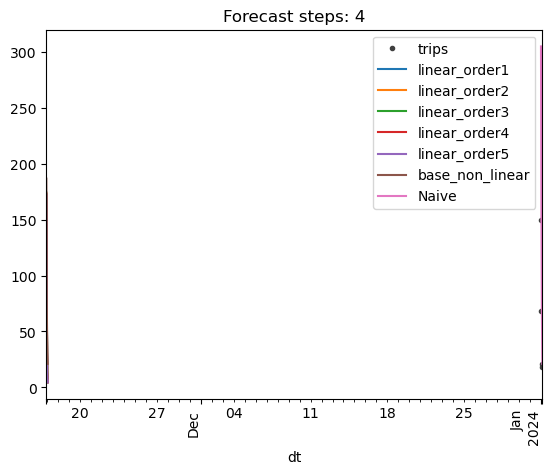

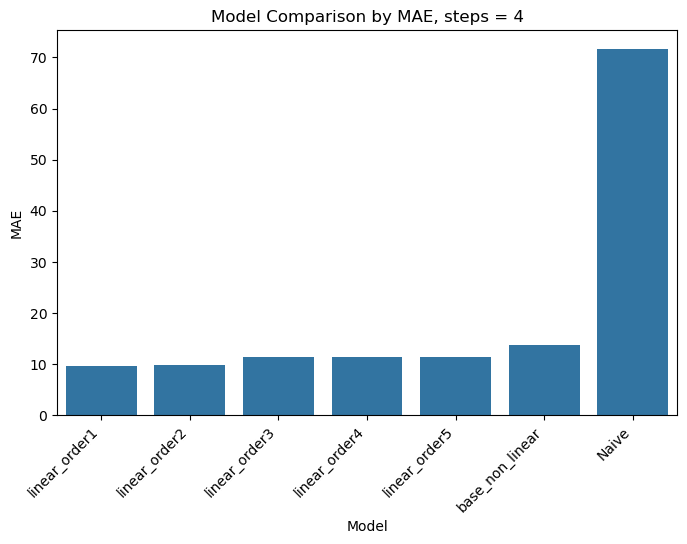

MAE Linear: 10.54 for step = 6, model = linear_order1
MAE Linear: 10.81 for step = 6, model = linear_order2
MAE Linear: 13.52 for step = 6, model = linear_order3
MAE Linear: 13.52 for step = 6, model = linear_order4
MAE Linear: 13.52 for step = 6, model = linear_order5
MAE Non Linear: 9.35 for step = 6, model = base_non_linear
Naive MAE: MAE = 54.50



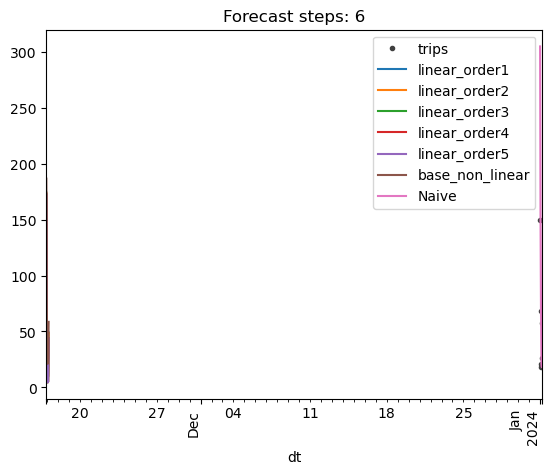

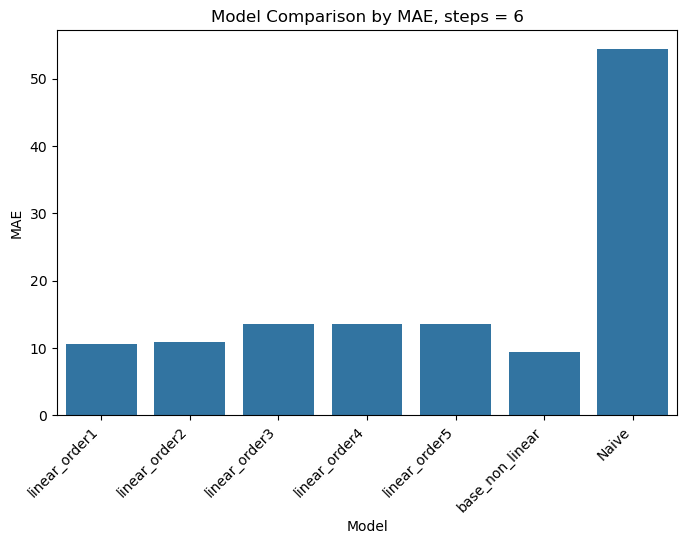

MAE Linear: 34.12 for step = 12, model = linear_order1
MAE Linear: 34.54 for step = 12, model = linear_order2
MAE Linear: 39.14 for step = 12, model = linear_order3
MAE Linear: 39.14 for step = 12, model = linear_order4
MAE Linear: 39.14 for step = 12, model = linear_order5
MAE Non Linear: 23.06 for step = 12, model = base_non_linear
Naive MAE: MAE = 55.75



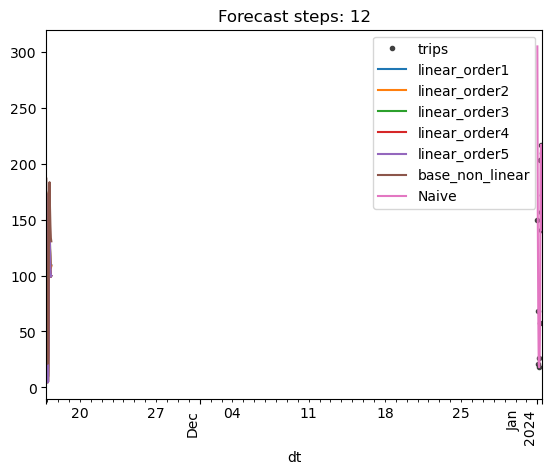

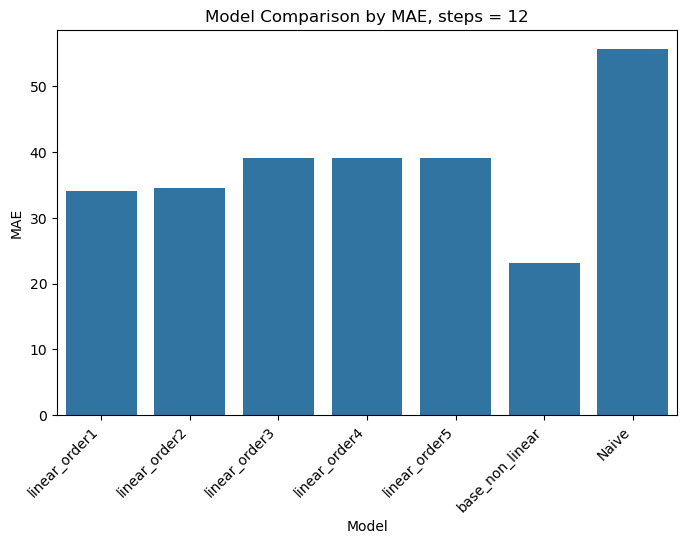

MAE Linear: 51.73 for step = 24, model = linear_order1
MAE Linear: 52.25 for step = 24, model = linear_order2
MAE Linear: 57.17 for step = 24, model = linear_order3
MAE Linear: 57.17 for step = 24, model = linear_order4
MAE Linear: 57.17 for step = 24, model = linear_order5
MAE Non Linear: 44.52 for step = 24, model = base_non_linear
Naive MAE: MAE = 53.67



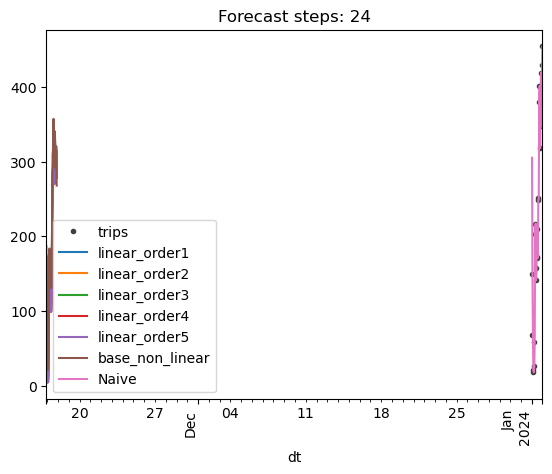

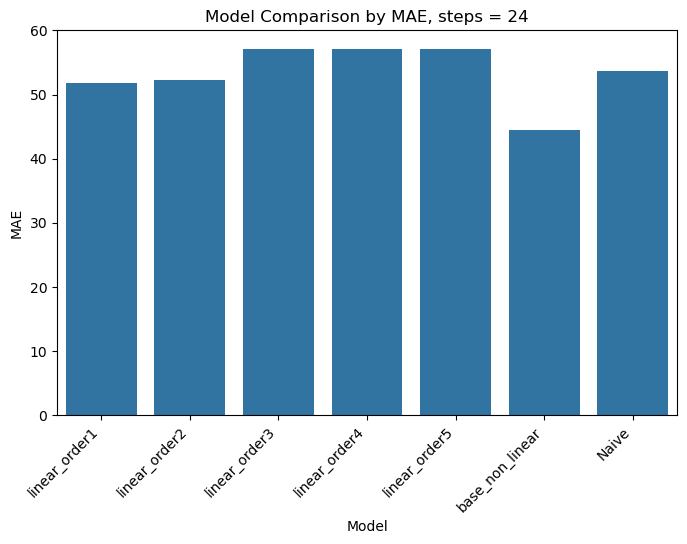

MAE Linear: 58.99 for step = 48, model = linear_order1
MAE Linear: 59.68 for step = 48, model = linear_order2
MAE Linear: 63.49 for step = 48, model = linear_order3
MAE Linear: 63.49 for step = 48, model = linear_order4
MAE Linear: 63.49 for step = 48, model = linear_order5
MAE Non Linear: 54.96 for step = 48, model = base_non_linear
Naive MAE: MAE = 62.92



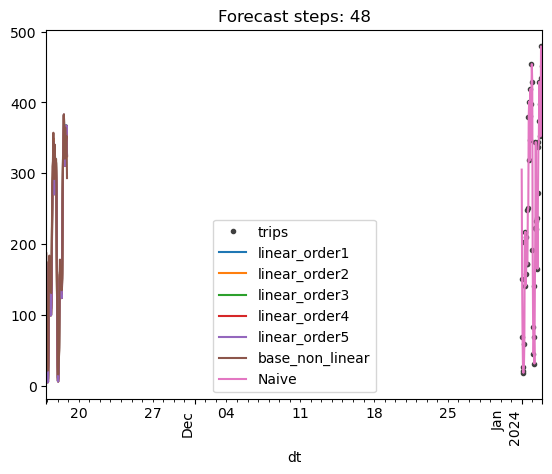

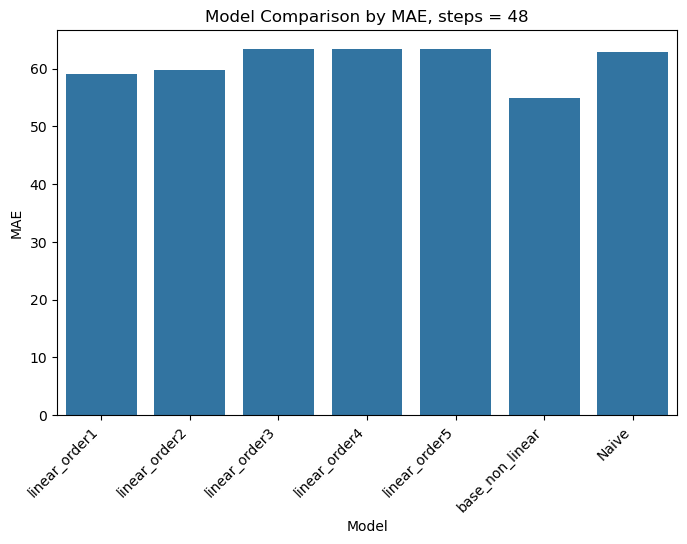

MAE Linear: 53.29 for step = 72, model = linear_order1
MAE Linear: 53.83 for step = 72, model = linear_order2
MAE Linear: 56.36 for step = 72, model = linear_order3
MAE Linear: 56.36 for step = 72, model = linear_order4
MAE Linear: 56.36 for step = 72, model = linear_order5
MAE Non Linear: 50.92 for step = 72, model = base_non_linear
Naive MAE: MAE = 65.71



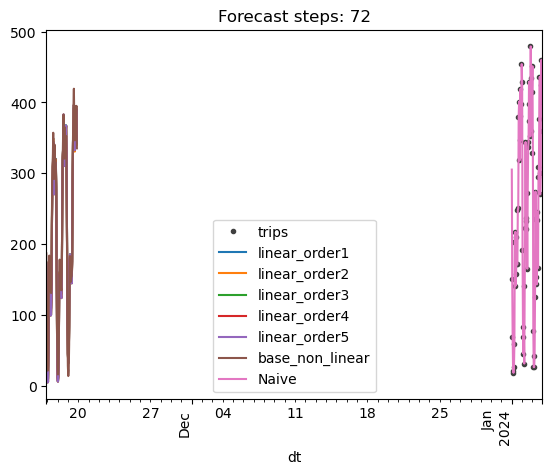

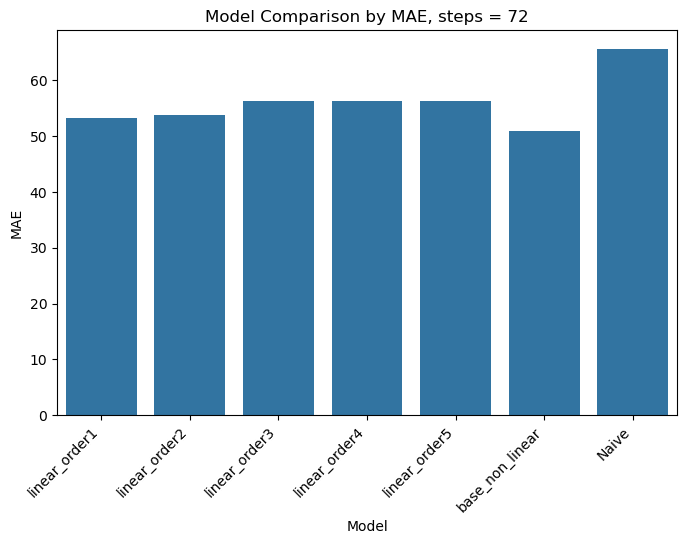

MAE Linear: 47.84 for step = 96, model = linear_order1
MAE Linear: 48.20 for step = 96, model = linear_order2
MAE Linear: 50.34 for step = 96, model = linear_order3
MAE Linear: 50.34 for step = 96, model = linear_order4
MAE Linear: 50.34 for step = 96, model = linear_order5
MAE Non Linear: 47.29 for step = 96, model = base_non_linear
Naive MAE: MAE = 64.10



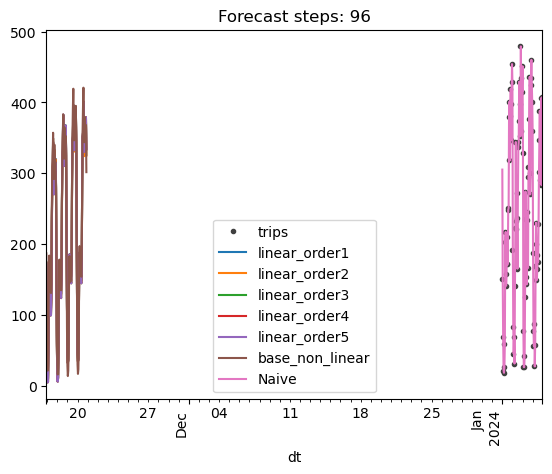

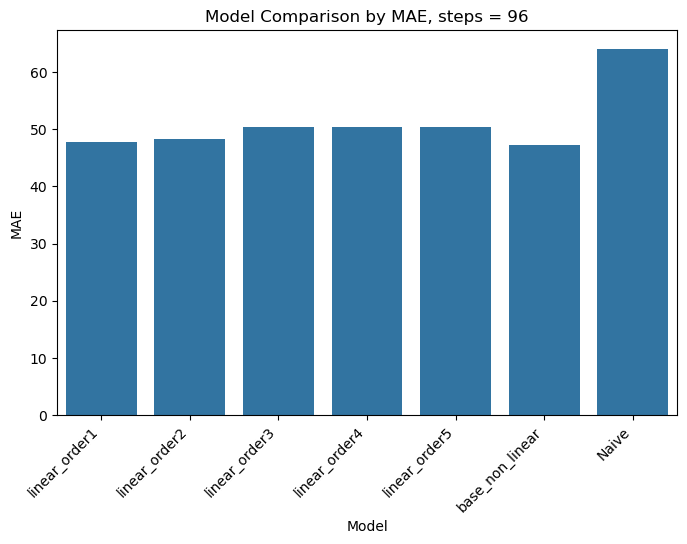

MAE Linear: 44.01 for step = 120, model = linear_order1
MAE Linear: 44.19 for step = 120, model = linear_order2
MAE Linear: 46.13 for step = 120, model = linear_order3
MAE Linear: 46.13 for step = 120, model = linear_order4
MAE Linear: 46.13 for step = 120, model = linear_order5
MAE Non Linear: 42.88 for step = 120, model = base_non_linear
Naive MAE: MAE = 62.22



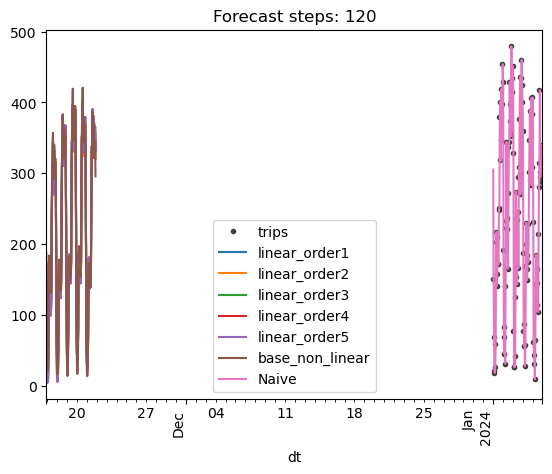

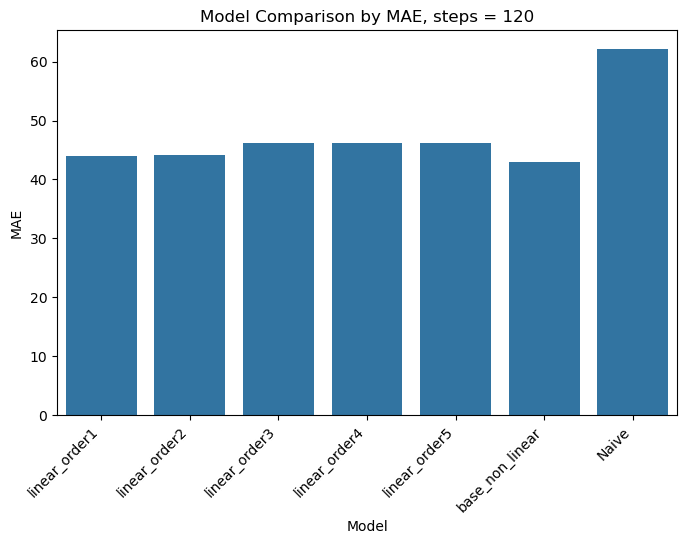

MAE Linear: 43.63 for step = 168, model = linear_order1
MAE Linear: 43.61 for step = 168, model = linear_order2
MAE Linear: 45.53 for step = 168, model = linear_order3
MAE Linear: 45.53 for step = 168, model = linear_order4
MAE Linear: 45.53 for step = 168, model = linear_order5
MAE Non Linear: 43.96 for step = 168, model = base_non_linear
Naive MAE: MAE = 59.89



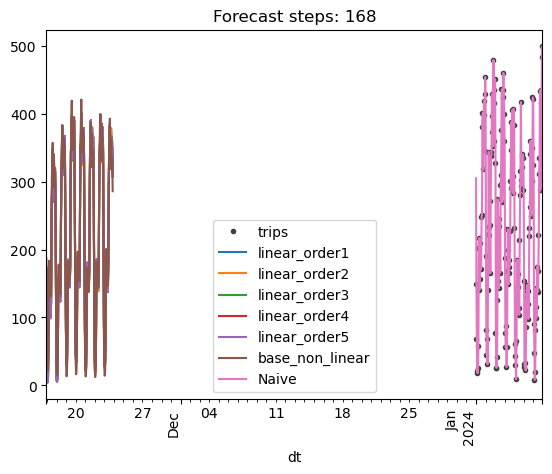

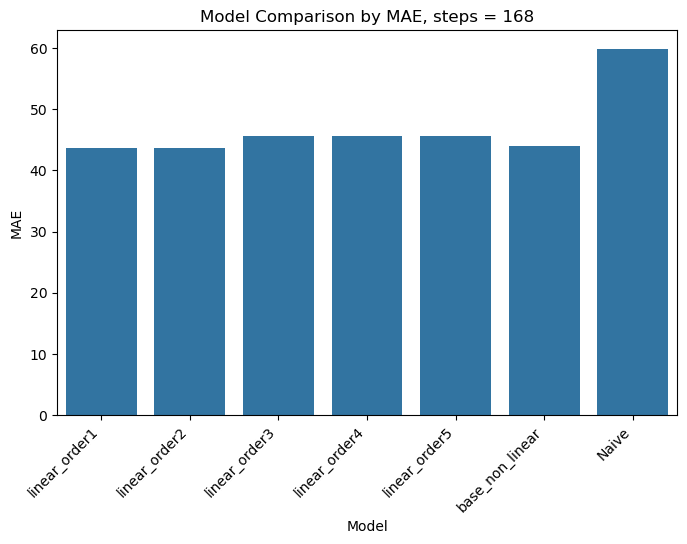

MAE Linear: 41.40 for step = 336, model = linear_order1
MAE Linear: 40.97 for step = 336, model = linear_order2
MAE Linear: 42.23 for step = 336, model = linear_order3
MAE Linear: 42.23 for step = 336, model = linear_order4
MAE Linear: 42.23 for step = 336, model = linear_order5
MAE Non Linear: 41.58 for step = 336, model = base_non_linear
Naive MAE: MAE = 51.21



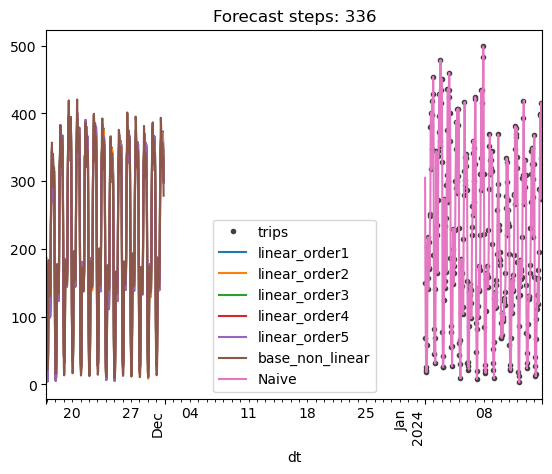

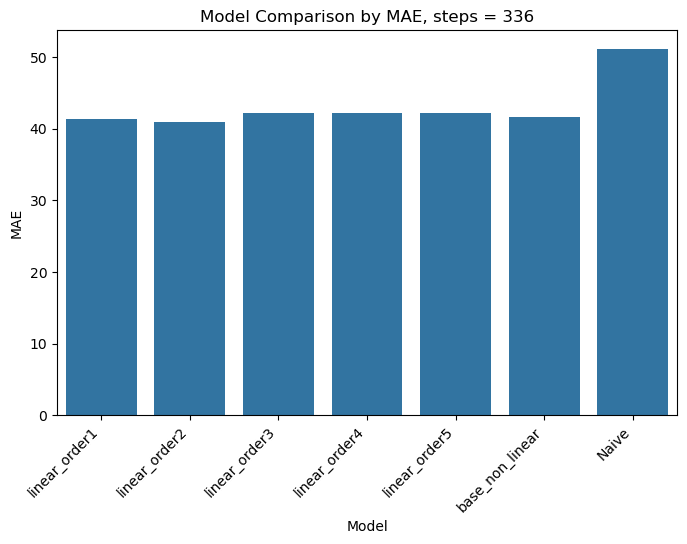

MAE Linear: 46.60 for step = 720, model = linear_order1
MAE Linear: 45.10 for step = 720, model = linear_order2
MAE Linear: 45.96 for step = 720, model = linear_order3
MAE Linear: 45.96 for step = 720, model = linear_order4
MAE Linear: 45.96 for step = 720, model = linear_order5
MAE Non Linear: 46.09 for step = 720, model = base_non_linear
Naive MAE: MAE = 50.33



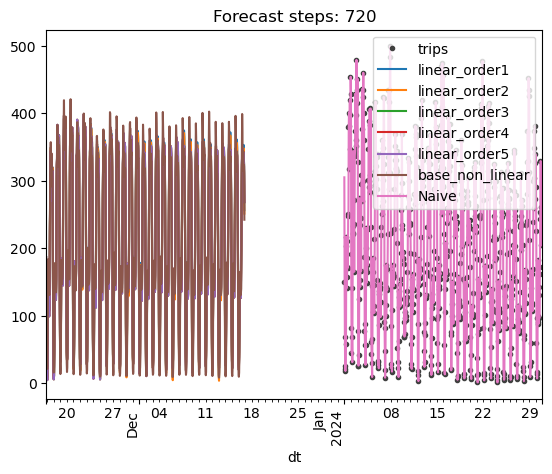

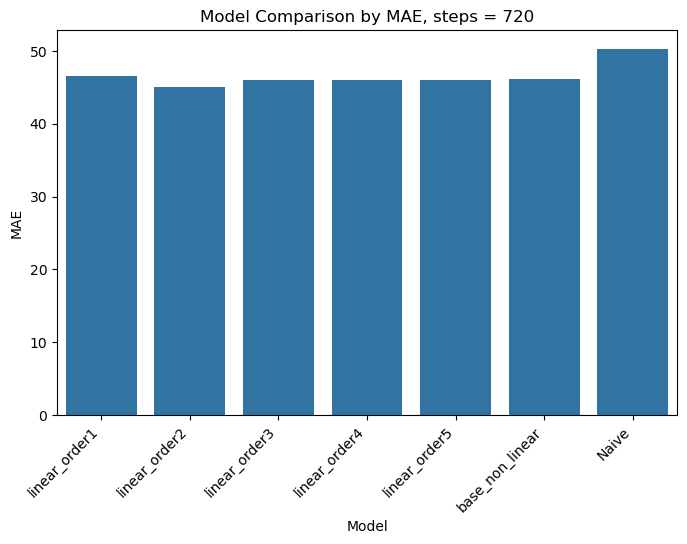

MAE Linear: 52.39 for step = 4320, model = linear_order1
MAE Linear: 54.30 for step = 4320, model = linear_order2
MAE Linear: 56.90 for step = 4320, model = linear_order3
MAE Linear: 56.90 for step = 4320, model = linear_order4
MAE Linear: 56.90 for step = 4320, model = linear_order5
MAE Non Linear: 47.63 for step = 4320, model = base_non_linear
Naive MAE: MAE = 52.23



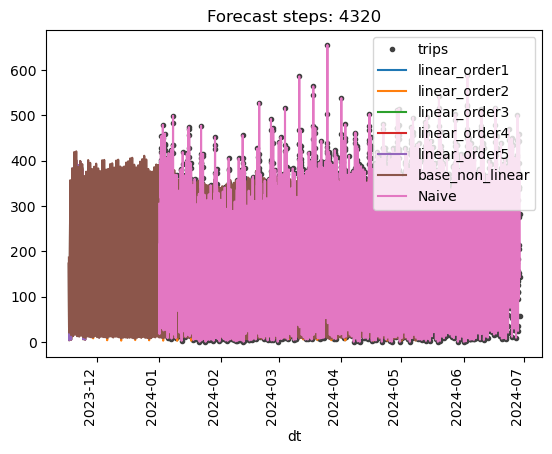

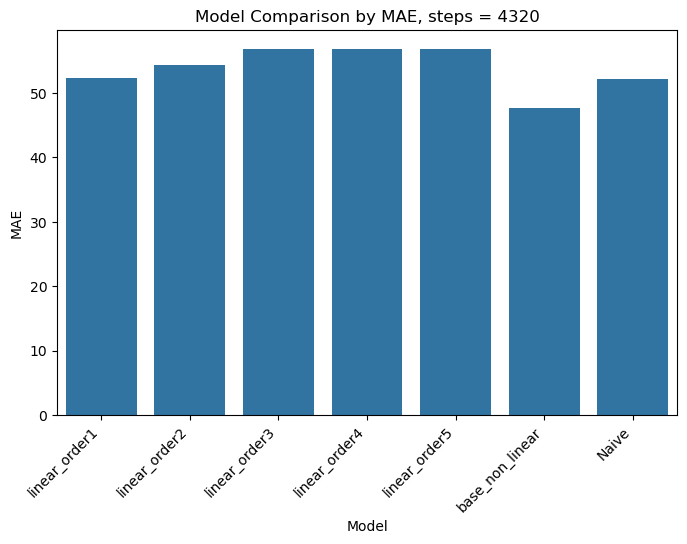

In [ ]:
# Run forecasts
run_forecasts(steps, hourly_lags_used, linear_models_loaded, non_linear_models_loaded, True, "h", ts_hourly_train, ts_hourly_test)